# Progetto BISF
Alessandro Zanotti 885892

### Importo le librerie necessarie al funzionamento del notebook

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from matplotlib import style
import urllib.request
import zipfile
import statsmodels.formula.api as smf

### Scarico i dati dei titoli scelti e li memorizzo in un DataFrame
- Settore tecnologico: AVGO, AMD
- Settore sanitario: LLY, PFE
- Settori finanziario: BRK.B, BLK

In [2]:
START_DATE = '2014-05-31'
END_DATE = '2024-05-31'
selected_stocks = ["AVGO","AMD","LLY","PFE","BRK-B","BLK"]

stocks_data = yf.download(selected_stocks, start=START_DATE, end=END_DATE)

#Creo un DataFrame contenente solo i dati di chiusura (Adj Close)
adj_close_data = stocks_data['Adj Close']
adj_close_data.head()

[*********************100%%**********************]  6 of 6 completed


Ticker       AMD       AVGO         BLK       BRK-B        LLY        PFE
Date                                                                     
2014-06-02  3.97  54.481552  235.882172  127.879997  48.572330  19.234701
2014-06-03  3.94  54.337032  237.870712  126.930000  48.458038  19.157005
2014-06-04  4.04  54.458717  239.520218  127.230003  48.351891  19.189379
2014-06-05  4.08  54.656448  240.381042  128.199997  48.645832  19.267071
2014-06-06  4.06  54.473919  243.506775  128.649994  48.686649  19.046946

### Mostro un grafico con l'andamento dei prezzi di chiusura

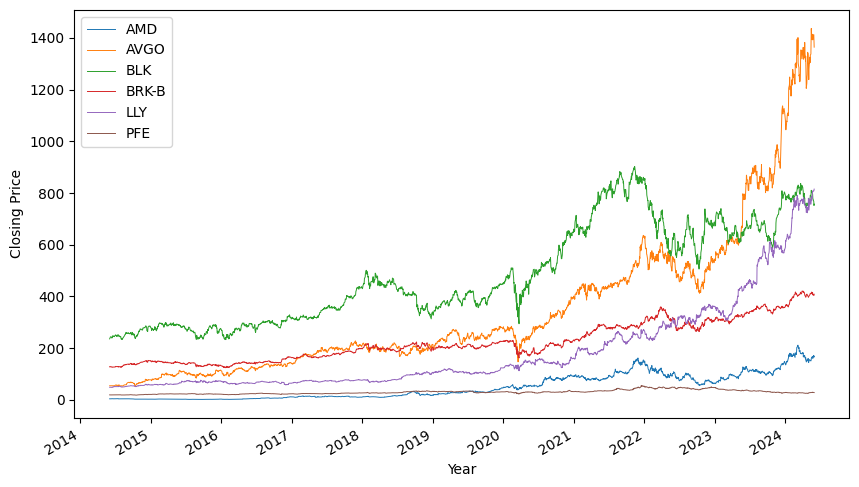

In [3]:
adj_close_data.plot(figsize=(10, 6), linewidth=0.7)
plt.legend()
plt.ylabel('Closing Price')
plt.xlabel('Year')
plt.show()

### Calcolo dei rendimenti semplici

In [4]:
adjusted_close_returns = adj_close_data.pct_change()
monthly_mean_returns = adjusted_close_returns.groupby(pd.Grouper(freq='ME')).mean()
adjusted_close_returns.dropna(inplace=True)
adjusted_close_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007557 -0.002653  0.008430 -0.007429 -0.002353 -0.004039
2014-06-04  0.025381  0.002239  0.006934  0.002364 -0.002191  0.001690
2014-06-05  0.009901  0.003631  0.003594  0.007624  0.006079  0.004049
2014-06-06 -0.004902 -0.003340  0.013003  0.003510  0.000839 -0.011425
2014-06-09  0.002463  0.002234  0.001943 -0.005130  0.001845 -0.002379

### Mostro un grafico con i rendimenti semplici calcolati per azione

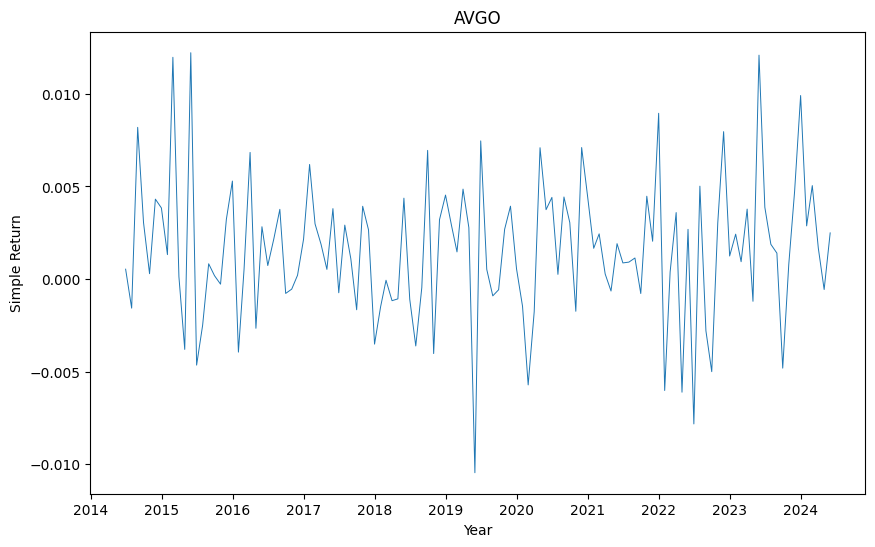

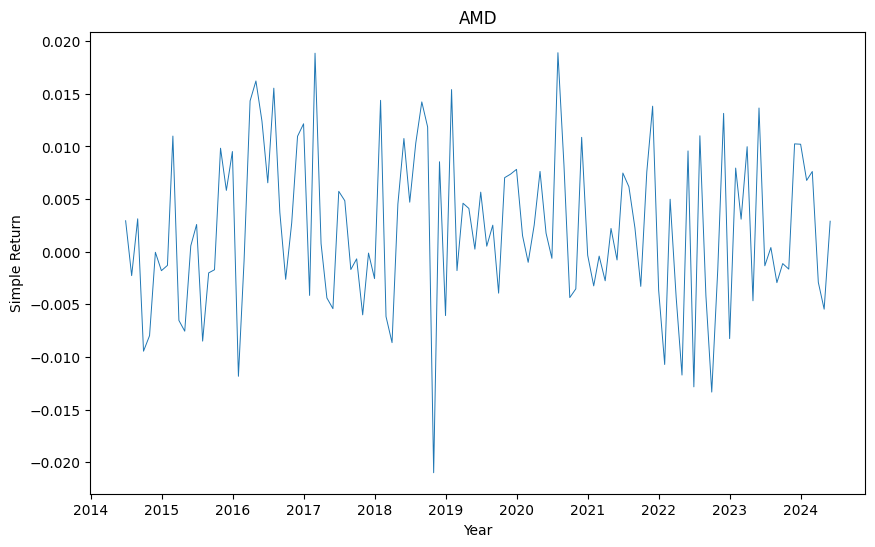

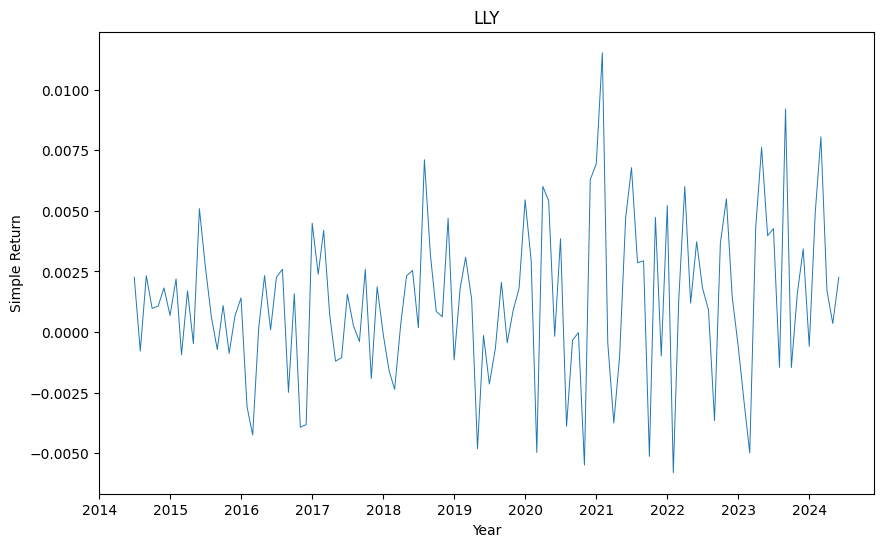

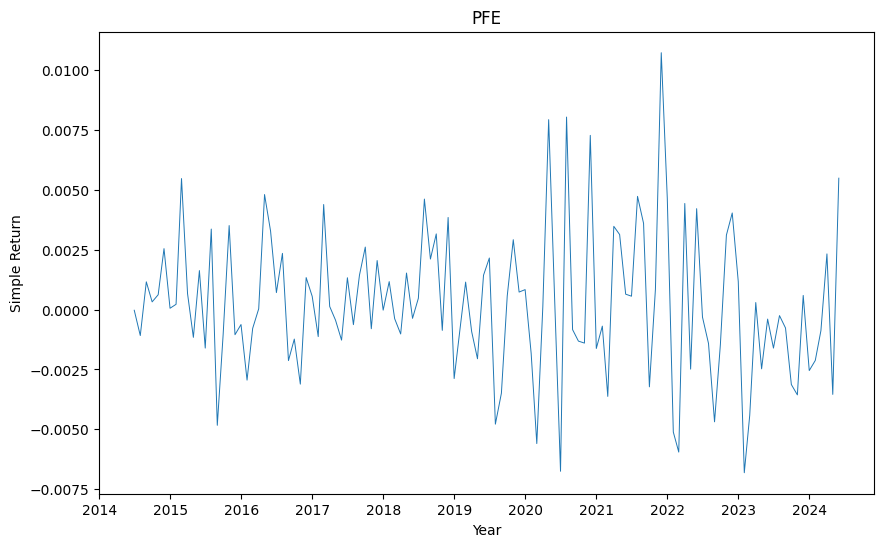

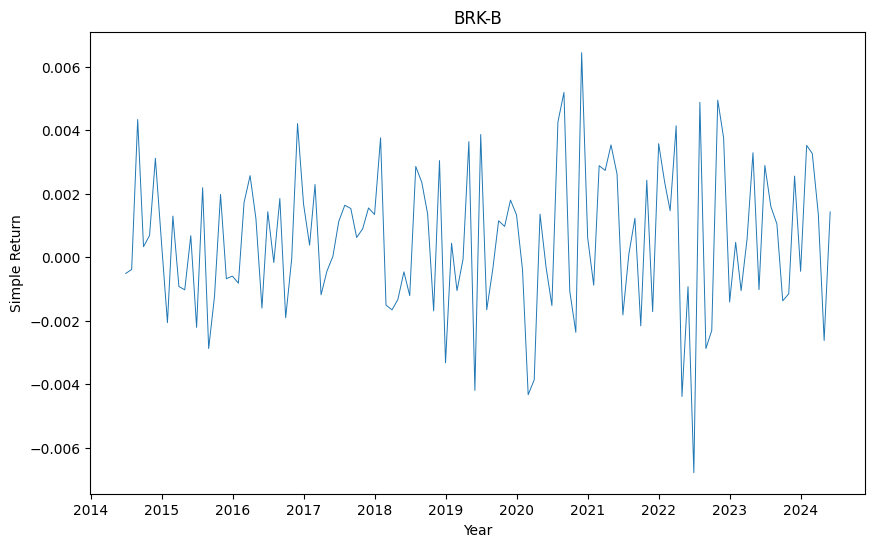

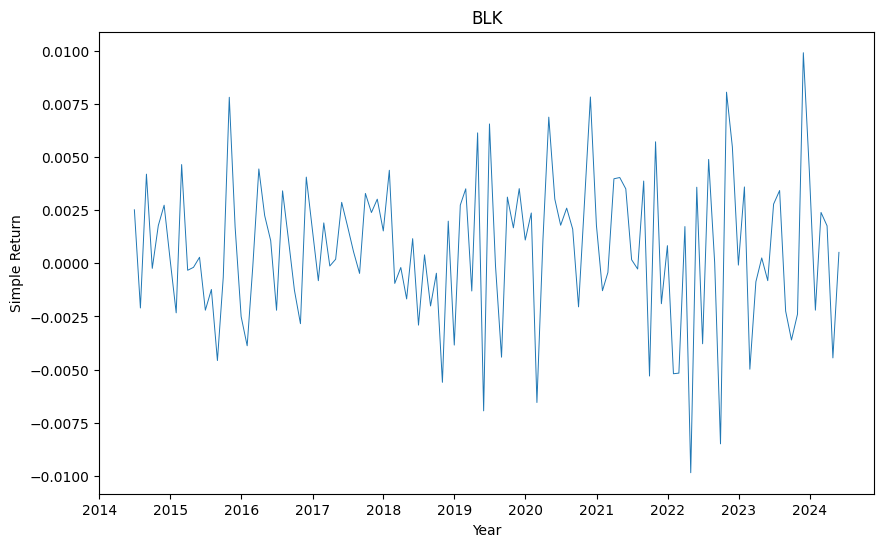

In [5]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_returns[ticker], linewidth=0.7)
    plt.ylabel('Simple Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

### Calcolo i rendimenti logaritmici

In [6]:
logarithmic_returns = np.log(adj_close_data / adj_close_data.shift(1))
monthly_mean_logarithmic_returns = logarithmic_returns.groupby(pd.Grouper(freq='ME')).mean()
logarithmic_returns.dropna(inplace=True)
logarithmic_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007585 -0.002656  0.008395 -0.007457 -0.002356 -0.004048
2014-06-04  0.025064  0.002237  0.006911  0.002361 -0.002193  0.001688
2014-06-05  0.009852  0.003624  0.003588  0.007595  0.006061  0.004041
2014-06-06 -0.004914 -0.003345  0.012919  0.003504  0.000839 -0.011491
2014-06-09  0.002460  0.002231  0.001941 -0.005143  0.001843 -0.002382

### Mostro le statistiche sui rendimenti logaritmici

In [7]:
logarithmic_returns.describe()

Ticker          AMD         AVGO          BLK        BRK-B          LLY  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001486     0.001280     0.000463     0.000462     0.001121   
std        0.036220     0.022179     0.017147     0.012110     0.016901   
min       -0.277456    -0.222056    -0.146815    -0.100838    -0.111094   
25%       -0.016697    -0.009964    -0.007751    -0.005321    -0.006760   
50%        0.000586     0.001316     0.000778     0.000481     0.000961   
75%        0.019693     0.012688     0.008739     0.006540     0.008839   
max        0.420617     0.146985     0.126843     0.109840     0.145656   

Ticker          PFE  
count   2516.000000  
mean       0.000152  
std        0.014355  
min       -0.080501  
25%       -0.006726  
50%        0.000000  
75%        0.007011  
max        0.103054

### Mostro un grafico con i rendimenti logaritmici calcolati per azione

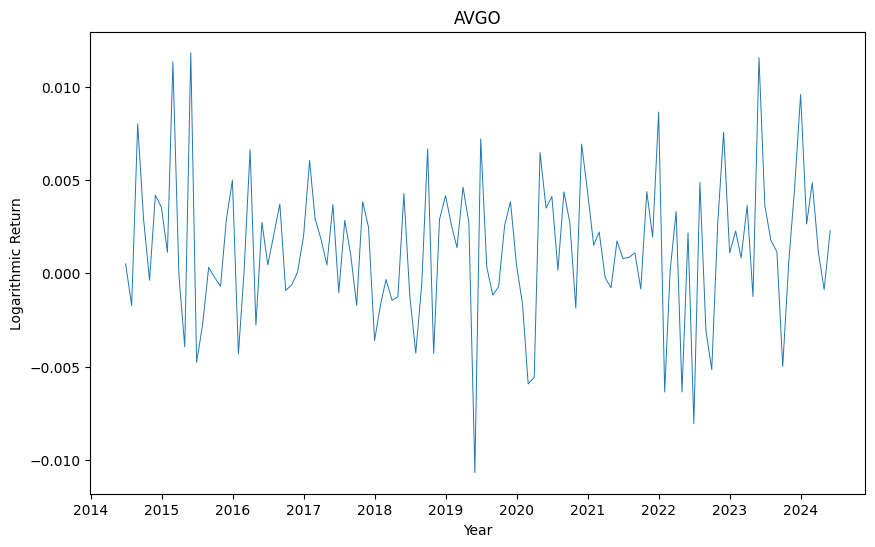

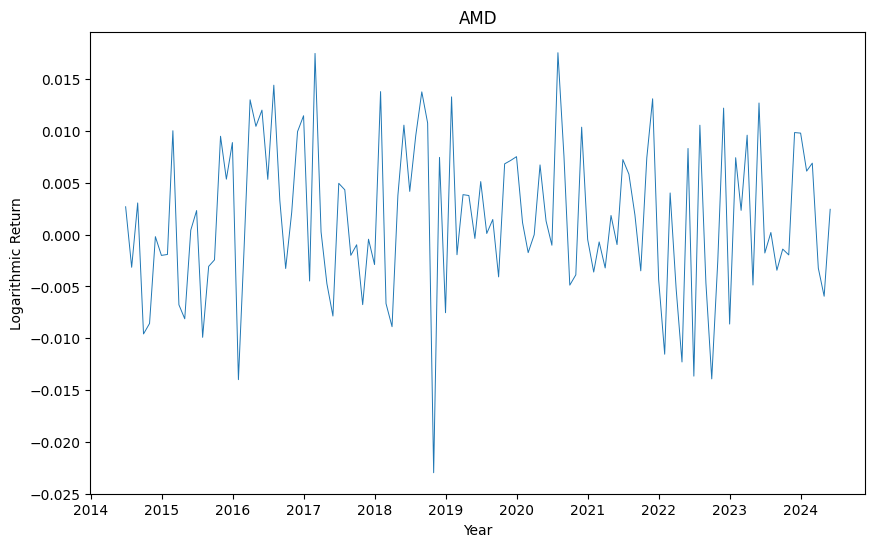

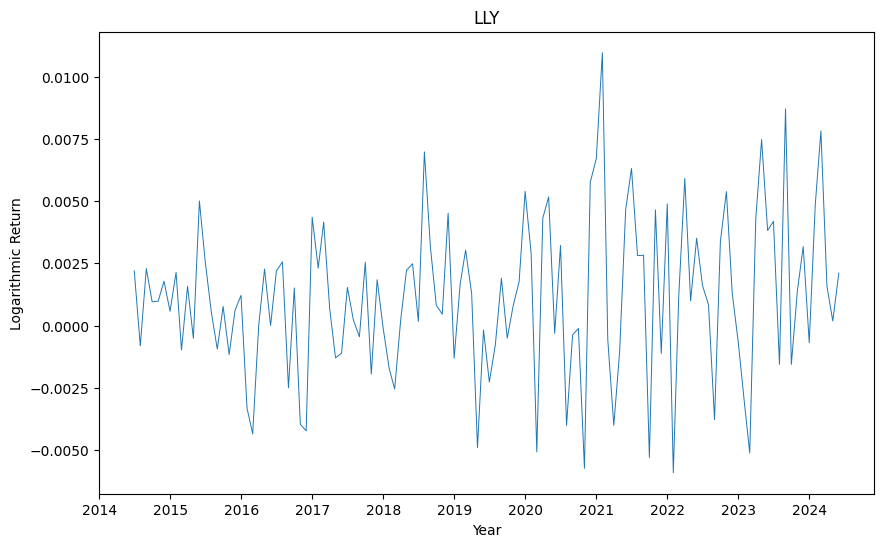

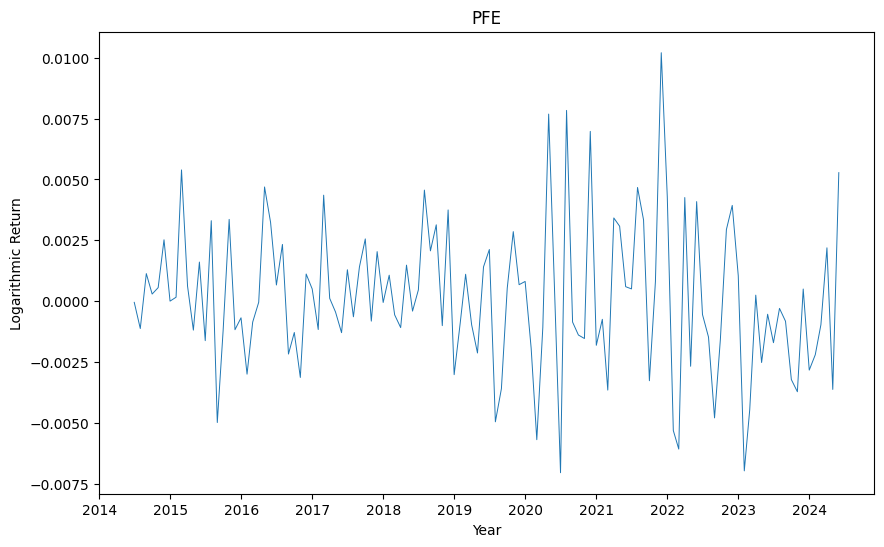

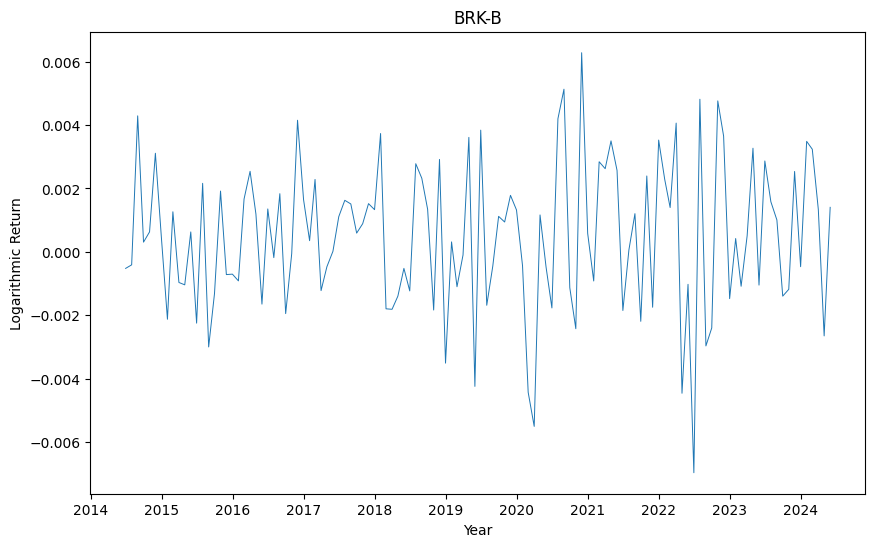

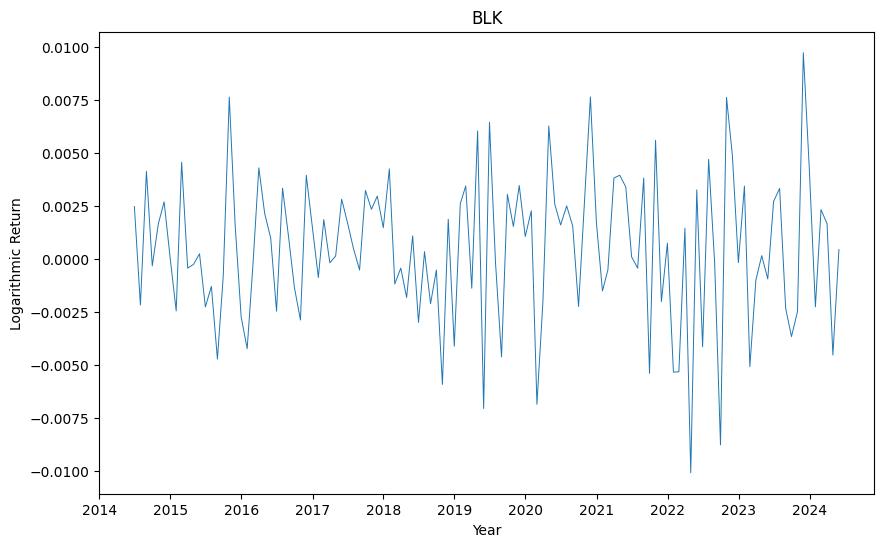

In [8]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_logarithmic_returns[ticker], linewidth=0.7)
    plt.ylabel('Logarithmic Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

### Calcola la media annuale dei prezzi di chiusura raggruppandoli per anno

In [9]:
annual_mean_adj_close = adj_close_data.groupby(pd.Grouper(freq='YE')).mean()

### Calcolo i rendimenti cumulati annui

In [10]:
annual_returns = adjusted_close_returns.groupby(pd.Grouper(freq='YE')).apply(lambda x: (1 + x).prod() - 1)
annual_returns.dropna(inplace=True)
annual_returns

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-12-31 -0.327456  0.420129  0.188917  0.174148  0.177529  0.066879
2015-12-31  0.074906  0.460370 -0.023545 -0.120613  0.253925  0.070880
2016-12-31  2.951220  0.236456  0.146379  0.234323 -0.103688  0.044249
2017-12-31 -0.093474  0.481861  0.381991  0.216223  0.178343  0.159018
2018-12-31  0.795720  0.036219 -0.216006  0.030068  0.404547  0.248189
2019-12-31  1.484291  0.290516  0.318653  0.109315  0.161400 -0.069079
2020-12-31  0.999782  0.448800  0.472051  0.023709  0.310399  0.030695
2021-12-31  0.569076  0.564849  0.293916  0.289516  0.660781  0.666951
2022-12-31 -0.549896 -0.132696 -0.203970  0.033110  0.342553 -0.104080
2023-12-31  1.275900  1.041842  0.178620  0.154613  0.609090 -0.412641
2024-12-31  0.131199  0.227224 -0.055694  0.145657  0.403075  0.009241

### Calcolo i rendimenti composti annui

In [11]:
annual_logarithmic_returns = np.log(annual_mean_adj_close / annual_mean_adj_close.shift(1))
annual_logarithmic_returns.dropna(inplace=True)
annual_logarithmic_returns

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2015-12-31 -0.407161  0.436897  0.071098  0.021573  0.219661  0.147835
2016-12-31  0.812548  0.237190  0.034775  0.027320 -0.005471  0.008661
2017-12-31  0.859473  0.425109  0.215937  0.195258  0.099625  0.075622
2018-12-31  0.327115  0.044281  0.172233  0.150505  0.157014  0.176448
2019-12-31  0.553479  0.225337 -0.065386  0.022084  0.240586  0.053604
2020-12-31  0.784645  0.158157  0.249153 -0.014826  0.265549 -0.041021
2021-12-31  0.432687  0.462506  0.437091  0.285351  0.430090  0.228561
2022-12-31 -0.106940  0.119425 -0.184594  0.110225  0.328184  0.199031
2023-12-31  0.125390  0.400170  0.035327  0.096150  0.424518 -0.264781
2024-12-31  0.494684  0.502737  0.155358  0.175223  0.463164 -0.253682

### Mostro un istogramma dei rendimenti logaritmici

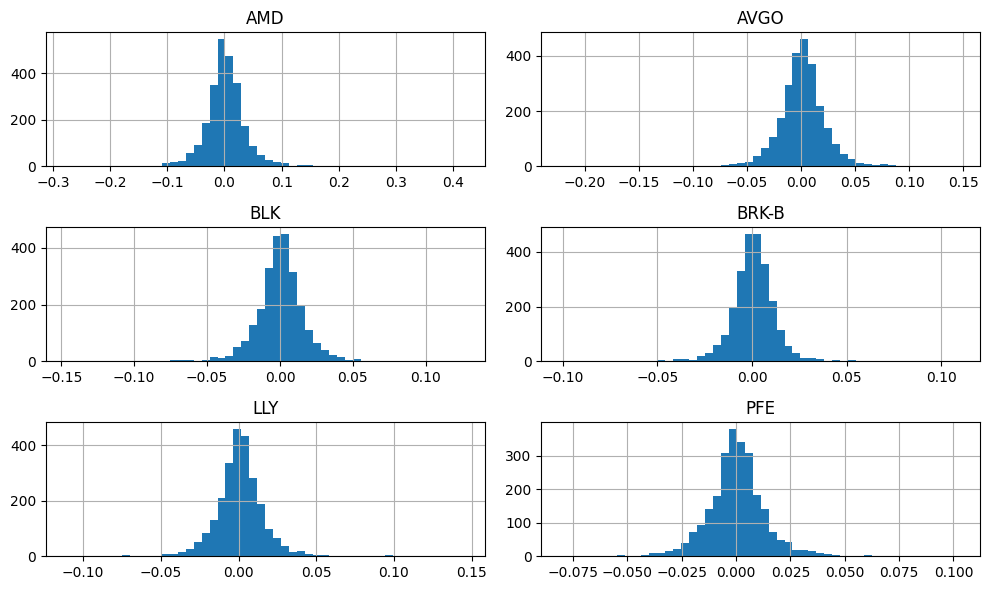

In [12]:
logarithmic_returns.hist(bins=50, figsize=(10, 6))
plt.tight_layout()
plt.show()

### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli tecnologici
- Broadcom: AVGO
- Advanced Micro Devices: AMD

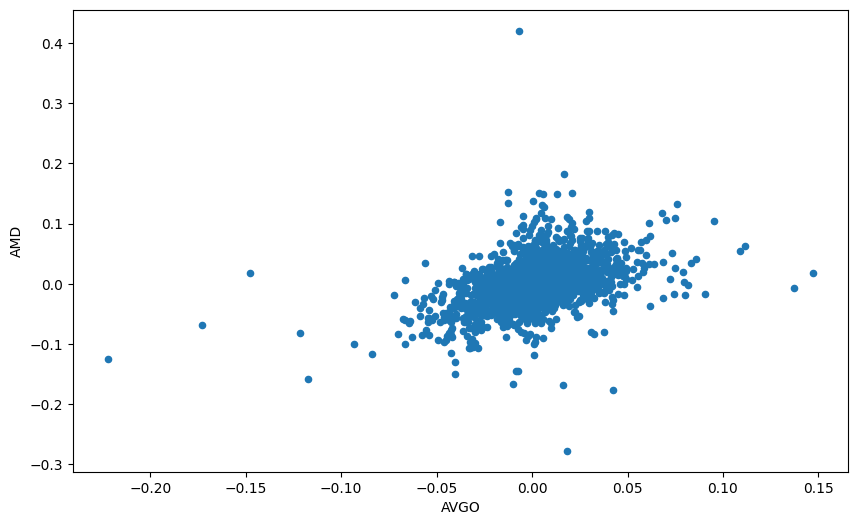

In [13]:
logarithmic_returns.plot(kind='scatter', x='AVGO', y='AMD', figsize=(10, 6))
plt.show()

### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli sanitari
- Eli Lilly: LLY
- Pfizer: PFE

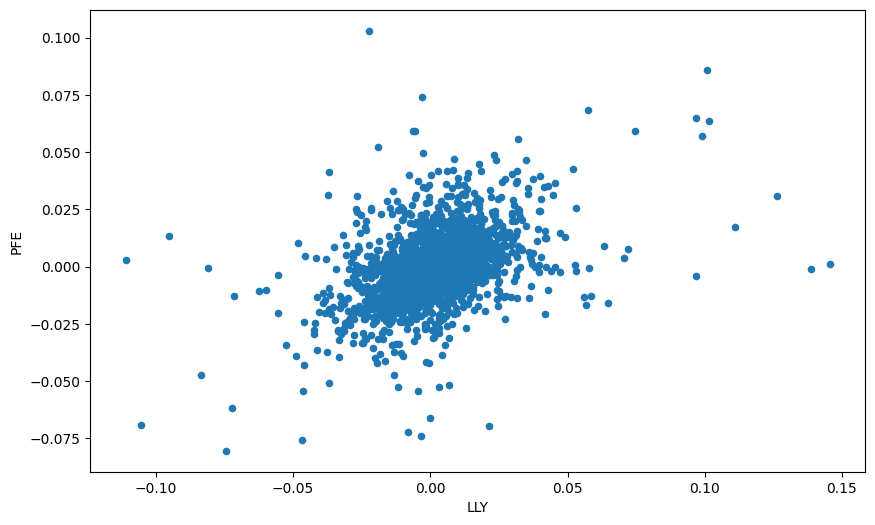

In [14]:
logarithmic_returns.plot(kind='scatter', x='LLY', y='PFE', figsize=(10, 6))
plt.show()

### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli finanziari
- Berkshire Hathaway: BRK-B
- Blackrock: BLK

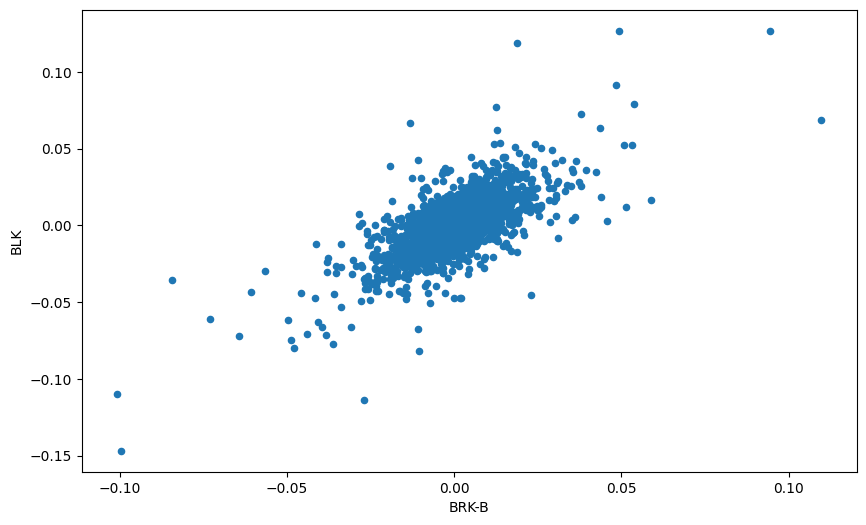

In [15]:
logarithmic_returns.plot(kind='scatter', x='BRK-B', y='BLK', figsize=(10, 6))
plt.show()

### Mostro i grafici diagnostici dei rendimenti logaritmici per titolo

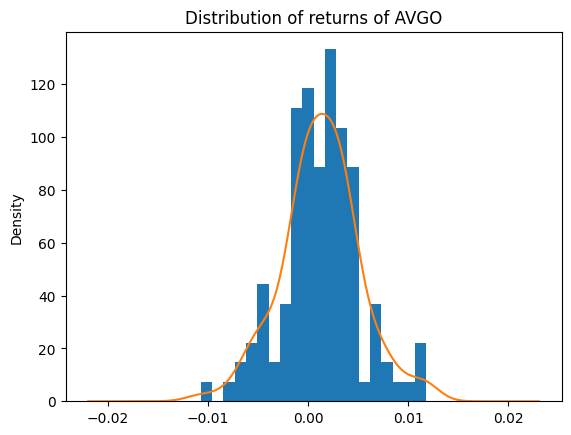

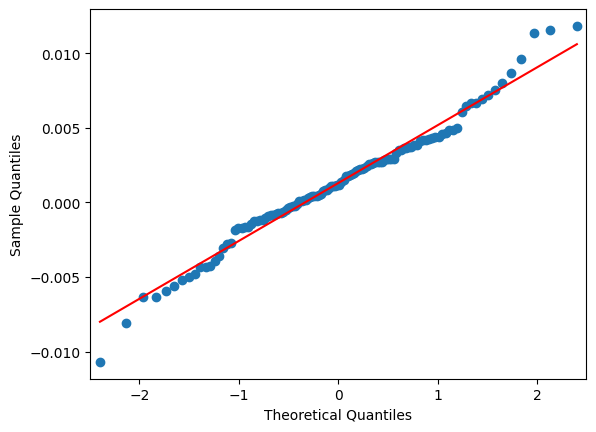

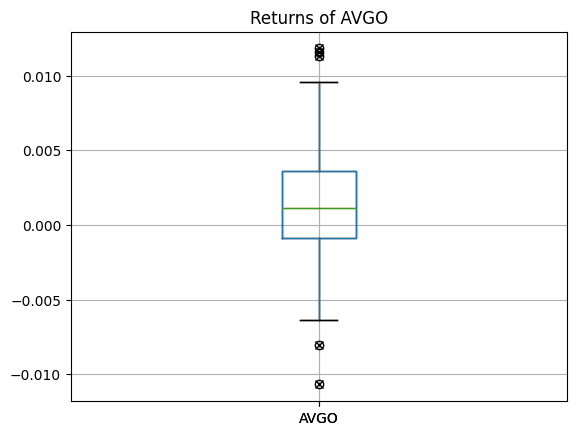

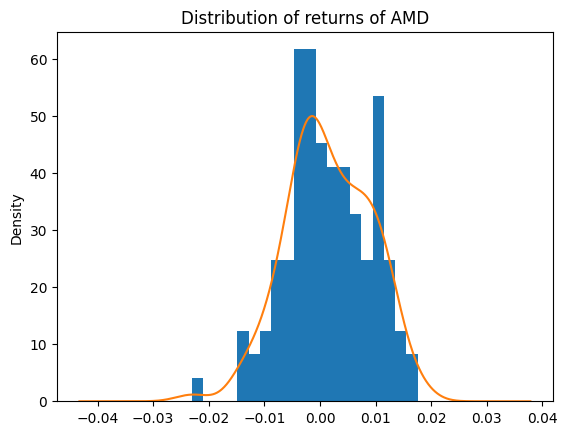

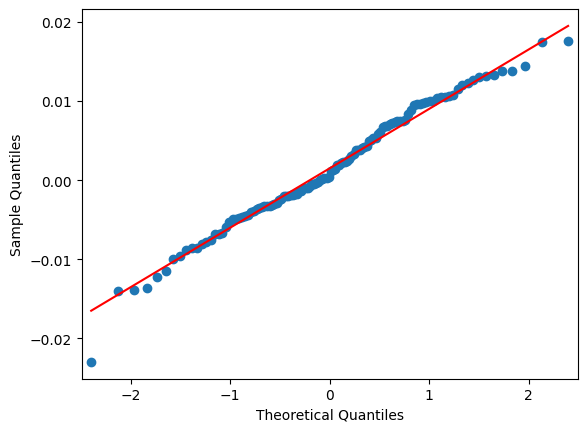

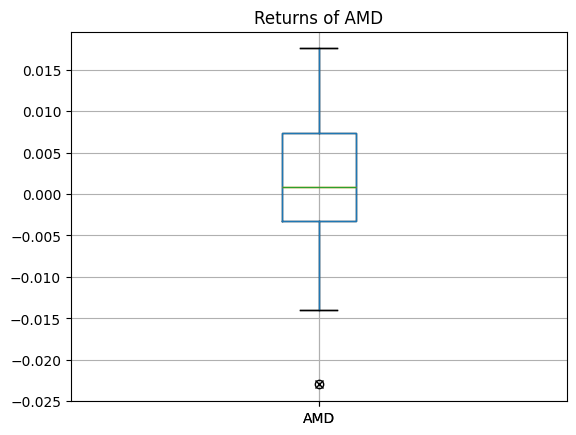

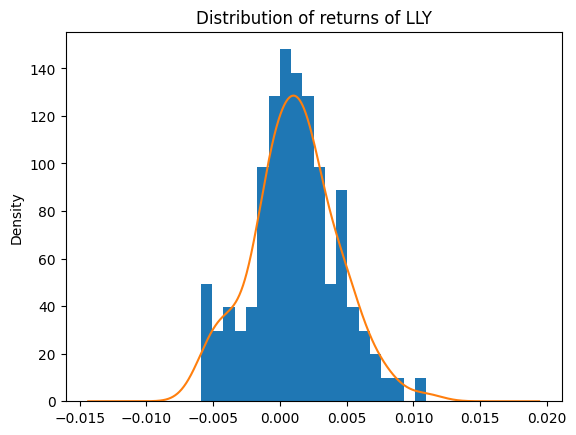

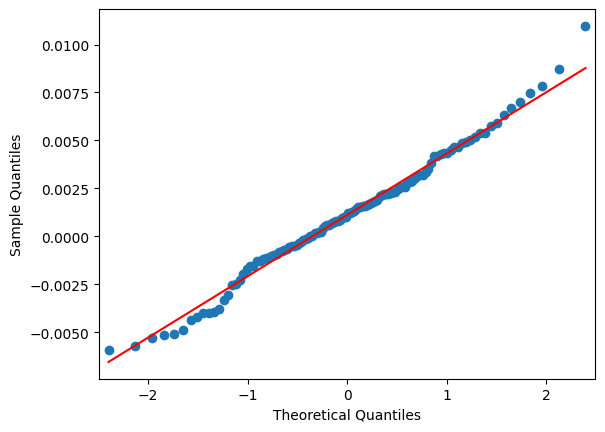

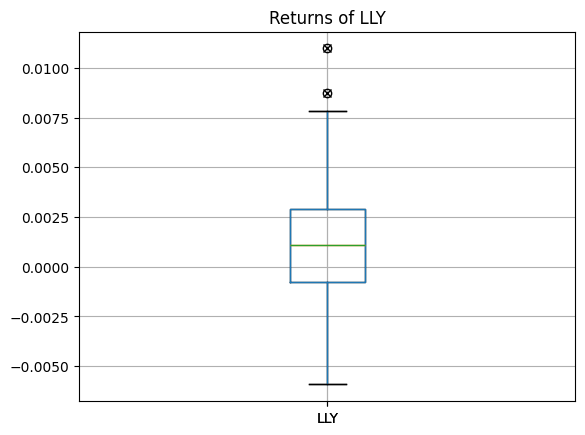

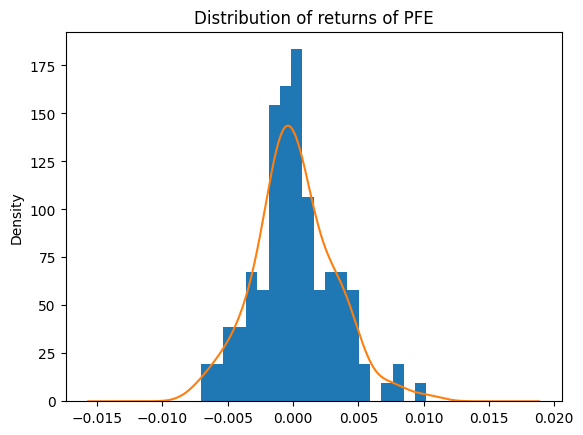

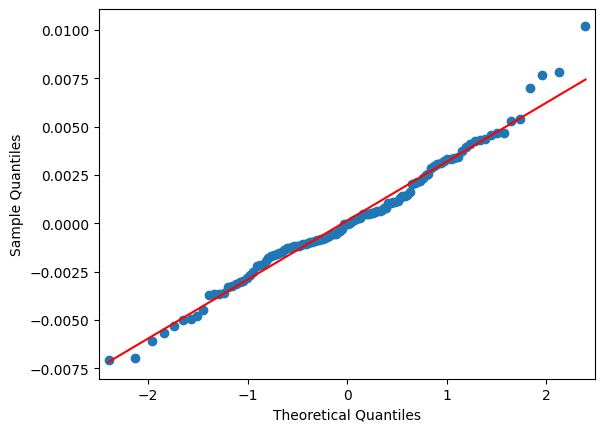

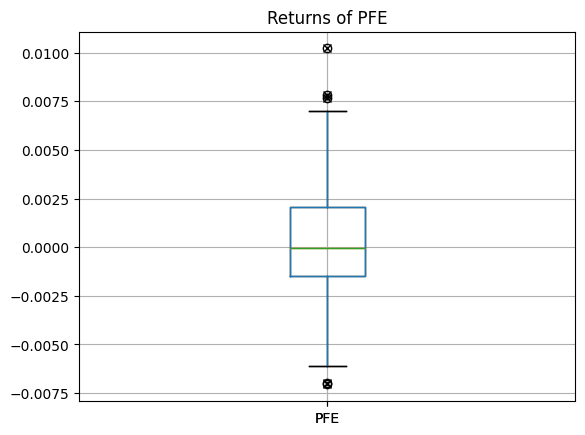

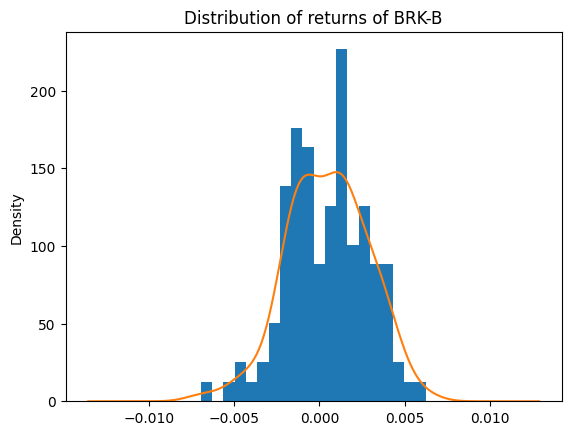

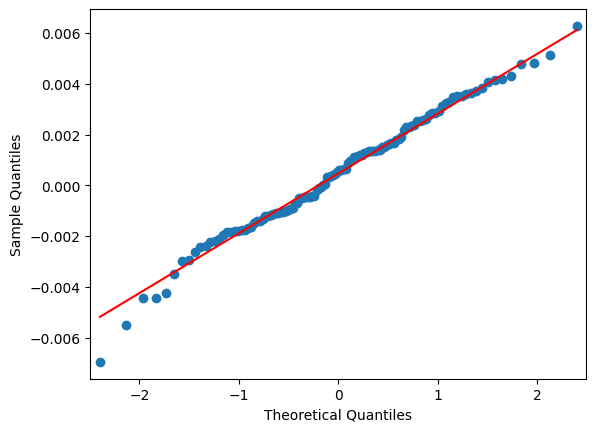

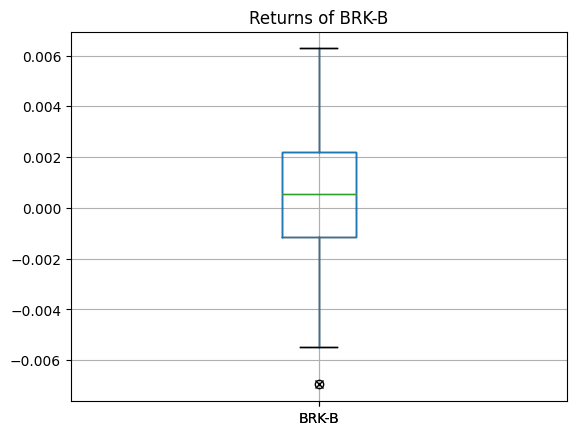

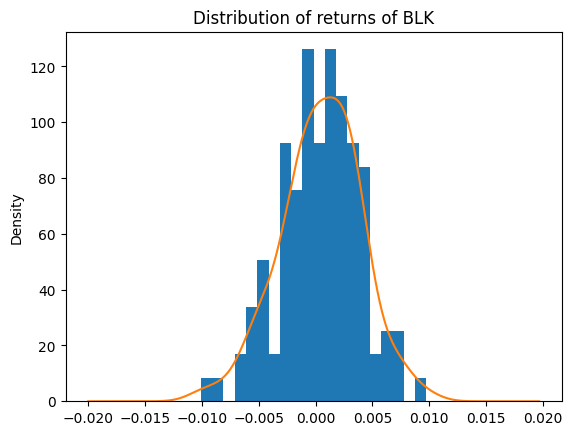

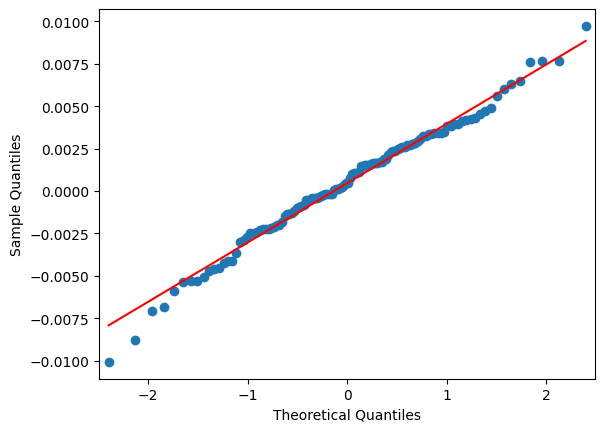

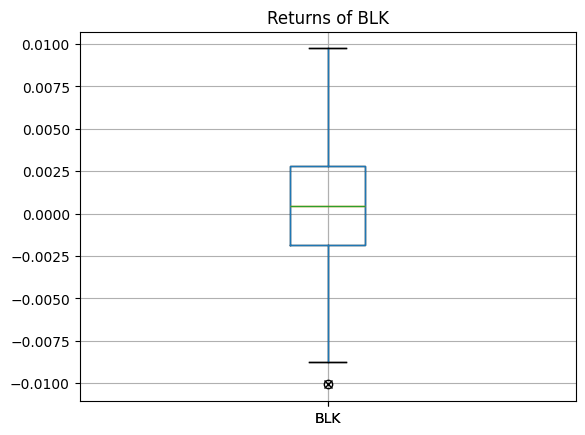

In [16]:
for ticker in selected_stocks:
    plt.figure()
    plt.hist(monthly_mean_logarithmic_returns[ticker], density = True, bins=20)
    plt.title(f"Distribution of returns of {ticker}")
    monthly_mean_logarithmic_returns[ticker].plot.density()

    sm.qqplot(monthly_mean_logarithmic_returns[ticker], line = 's')

    plt.figure()
    plt.boxplot(monthly_mean_logarithmic_returns[ticker], sym = 'x')
    plt.title(f"Returns of {ticker}")
    monthly_mean_logarithmic_returns[ticker].to_frame().boxplot()

plt.show()

### Calcolo le statistiche descrittive univariate
- Media
- Varianza
- Deviazione Standard
- Asimmetria
- Curtosi

In [17]:
for ticker in selected_stocks:
    mean_return = round(logarithmic_returns[ticker].mean(), 4)
    variance_return = round(logarithmic_returns[ticker].var(), 4)
    std_deviation_return = round(logarithmic_returns[ticker].std(), 4)
    skewness_return = round(logarithmic_returns[ticker].skew(), 4)
    kurtosis_return = round(logarithmic_returns[ticker].kurtosis(), 4)
    
    print(f"Ticker: {ticker}")
    print(f"Average: {mean_return}")
    print(f"Variance: {variance_return}")
    print(f"Standard Deviation: {std_deviation_return}")
    print(f"Skew: {skewness_return}")
    print(f"Kurtosis: {kurtosis_return}")
    print()

Ticker: AVGO
Average: 0.0013
Variance: 0.0005
Standard Deviation: 0.0222
Skew: -0.4277
Kurtosis: 9.3448

Ticker: AMD
Average: 0.0015
Variance: 0.0013
Standard Deviation: 0.0362
Skew: 0.4757
Kurtosis: 10.6656

Ticker: LLY
Average: 0.0011
Variance: 0.0003
Standard Deviation: 0.0169
Skew: 0.7396
Kurtosis: 10.7269

Ticker: PFE
Average: 0.0002
Variance: 0.0002
Standard Deviation: 0.0144
Skew: 0.1503
Kurtosis: 5.1215

Ticker: BRK-B
Average: 0.0005
Variance: 0.0001
Standard Deviation: 0.0121
Skew: -0.2482
Kurtosis: 11.2449

Ticker: BLK
Average: 0.0005
Variance: 0.0003
Standard Deviation: 0.0171
Skew: -0.1606
Kurtosis: 8.7427



### Calcolo la correlazione tra i rendimenti logaritmici dei titoli tecnologici

In [18]:
it_sector_correlation = logarithmic_returns['AMD'].corr(logarithmic_returns['AVGO'])
print(f"IT Sector Correlation: {it_sector_correlation}")

IT Sector Correlation: 0.4469595781501732


### Calcolo la correlazione tra i rendimenti logaritmici dei titoli sanitari

In [19]:
healthcare_sector_correlation = logarithmic_returns['PFE'].corr(logarithmic_returns['LLY'])
print(f"Healthcare Sector Correlation: {healthcare_sector_correlation}")

Healthcare Sector Correlation: 0.43407887054160393


### Calcolo la correlazione tra i rendimenti logaritmici dei titoli finanziari

In [20]:
finance_sector_correlation = logarithmic_returns['BLK'].corr(logarithmic_returns['BRK-B'])
print(f"Finance Sector Correlation: {finance_sector_correlation}")

Finance Sector Correlation: 0.706424263491684


### Calcolo matrice di covarianza

In [21]:
covariance_matrix = logarithmic_returns.cov()
print(covariance_matrix)

Ticker       AMD      AVGO       BLK     BRK-B       LLY       PFE
Ticker                                                            
AMD     0.001312  0.000359  0.000233  0.000137  0.000104  0.000093
AVGO    0.000359  0.000492  0.000207  0.000130  0.000094  0.000081
BLK     0.000233  0.000207  0.000294  0.000147  0.000094  0.000099
BRK-B   0.000137  0.000130  0.000147  0.000147  0.000076  0.000081
LLY     0.000104  0.000094  0.000094  0.000076  0.000286  0.000105
PFE     0.000093  0.000081  0.000099  0.000081  0.000105  0.000206


### Calcolo matrice di correlazione

In [22]:
correlation_matrix = logarithmic_returns.corr()
print(correlation_matrix)

Ticker       AMD      AVGO       BLK     BRK-B       LLY       PFE
Ticker                                                            
AMD     1.000000  0.446960  0.374661  0.312397  0.169330  0.178133
AVGO    0.446960  1.000000  0.543172  0.485652  0.251777  0.255830
BLK     0.374661  0.543172  1.000000  0.706424  0.325222  0.403830
BRK-B   0.312397  0.485652  0.706424  1.000000  0.368904  0.463404
LLY     0.169330  0.251777  0.325222  0.368904  1.000000  0.434079
PFE     0.178133  0.255830  0.403830  0.463404  0.434079  1.000000


### Calcolo correlazione nel tempo per ogni settore

In [23]:
it_sector_correlation_over_time = logarithmic_returns['AMD'].rolling(window=90).corr(logarithmic_returns['AVGO'])
healthcare_sector_correlation_over_time = logarithmic_returns['PFE'].rolling(window=90).corr(logarithmic_returns['LLY'])
finance_sector_correlation_over_time = logarithmic_returns['BLK'].rolling(window=90).corr(logarithmic_returns['BRK-B'])

### Mostro grafico correlazione nel tempo per il settore tecnologico

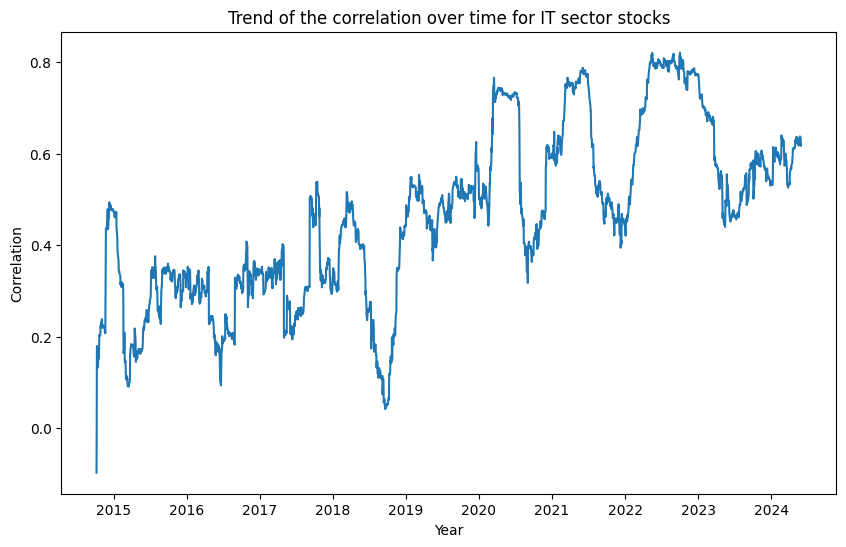

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(it_sector_correlation_over_time.index, it_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for IT sector stocks')
plt.show()

### Mostro grafico correlazione nel tempo per il settore sanitario

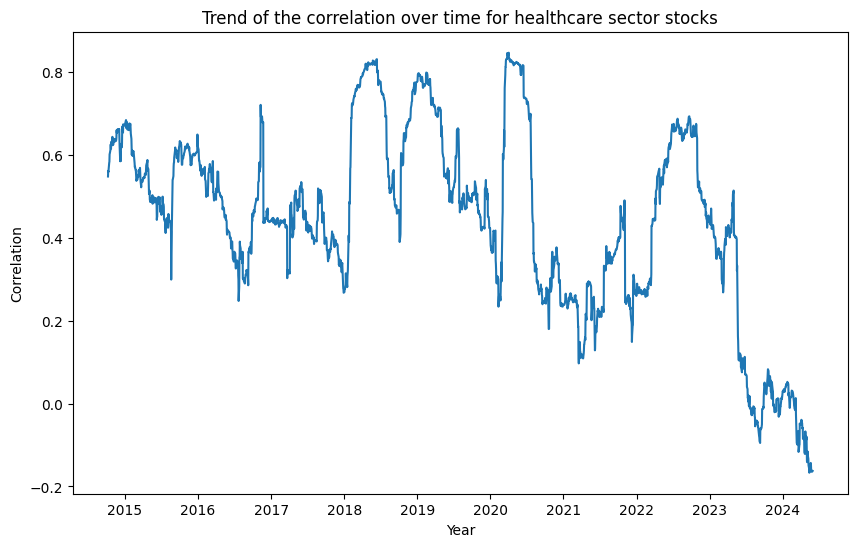

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(healthcare_sector_correlation_over_time.index, healthcare_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for healthcare sector stocks')
plt.show()

### Mostro grafico correlazione nel tempo per il settore bancario

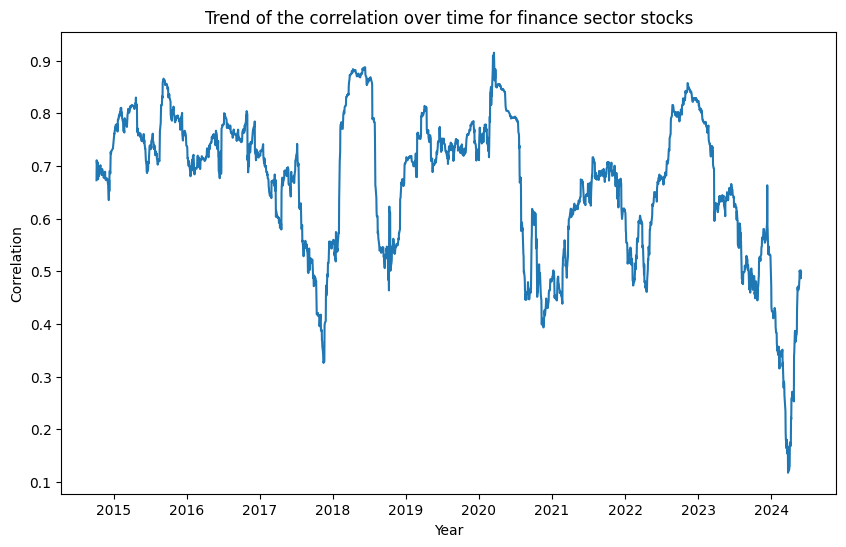

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(finance_sector_correlation_over_time.index, finance_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for finance sector stocks')
plt.show()

### Calcolo media delle correlazioni

In [27]:
mean_correlation = correlation_matrix.mean()

### Mostro il grafico di dispersione delle correlazione medie tra i titoli tecnologici

Text(0, 0.5, 'AMD')

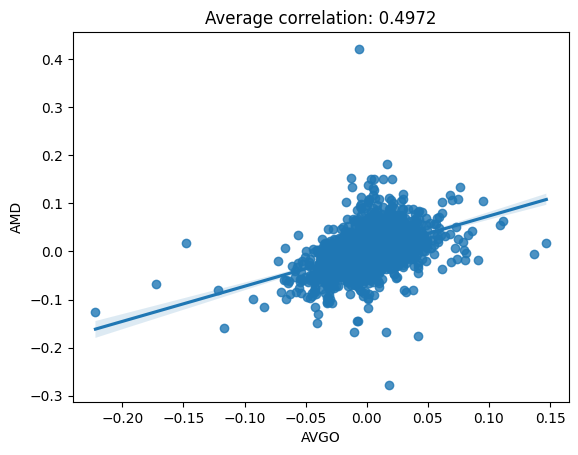

In [28]:
plt.figure()
sns.regplot(x=logarithmic_returns['AVGO'], y=logarithmic_returns['AMD'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['AVGO'], 4)))
plt.xlabel('AVGO')
plt.ylabel('AMD')

### Mostro il grafico di dispersione delle correlazione medie tra i titoli sanitari

Text(0, 0.5, 'PFE')

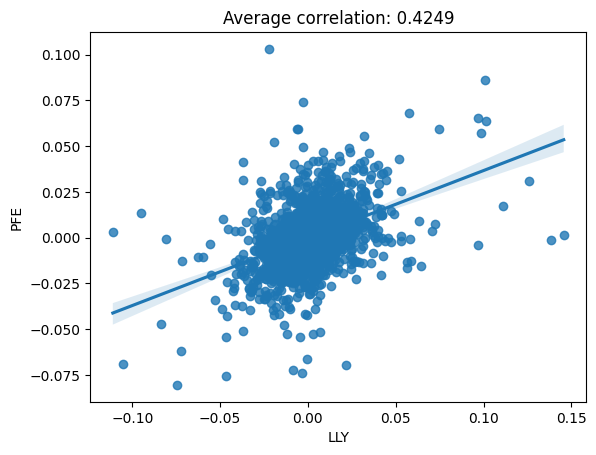

In [29]:
plt.figure()
sns.regplot(x=logarithmic_returns['LLY'], y=logarithmic_returns['PFE'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['LLY'], 4)))
plt.xlabel('LLY')
plt.ylabel('PFE')

### Mostro il grafico di dispersione delle correlazione medie tra i titoli bancari

Text(0, 0.5, 'BLK')

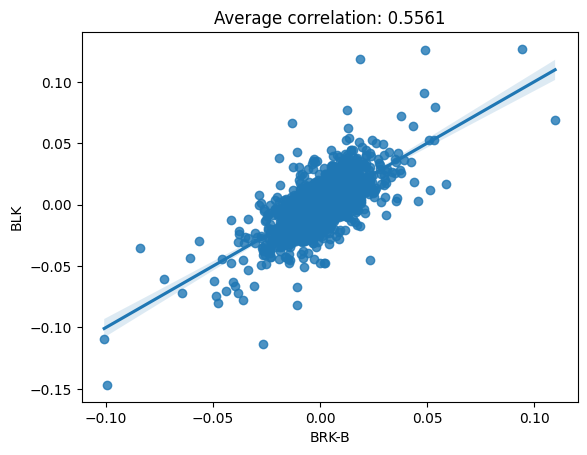

In [30]:
plt.figure()
sns.regplot(x=logarithmic_returns['BRK-B'], y=logarithmic_returns['BLK'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['BRK-B'], 4)))
plt.xlabel('BRK-B')
plt.ylabel('BLK')

### Creo colonna con prezzo previsto a 5 giorni

In [31]:
FORECAST_DAYS = 5
for ticker in selected_stocks:
    column_position = adj_close_data.columns.get_loc(ticker) + 1
    adj_close_data.insert(
        column_position,
        f"{ticker}_5_Days_Price_Forecast",
        adj_close_data[ticker].shift(-FORECAST_DAYS)
    )

print(adj_close_data.head(12))

Ticker       AMD  AMD_5_Days_Price_Forecast       AVGO  \
Date                                                     
2014-06-02  3.97                       4.07  54.481552   
2014-06-03  3.94                       4.20  54.337032   
2014-06-04  4.04                       4.29  54.458717   
2014-06-05  4.08                       4.29  54.656448   
2014-06-06  4.06                       4.28  54.473919   
2014-06-09  4.07                       4.44  54.595612   
2014-06-10  4.20                       4.47  54.648846   
2014-06-11  4.29                       4.40  54.565197   
2014-06-12  4.29                       4.36  54.572784   
2014-06-13  4.28                       4.10  54.314228   
2014-06-16  4.44                       4.01  53.903557   
2014-06-17  4.47                       3.94  54.583176   

Ticker      AVGO_5_Days_Price_Forecast         BLK  BLK_5_Days_Price_Forecast  \
Date                                                                            
2014-06-02               

### Divido il dataset in base ai titoli

In [32]:
adj_close_forecasts = [
    adj_close_data[[ticker, f"{ticker}_5_Days_Price_Forecast"]]
    for ticker in selected_stocks
]

print(adj_close_forecasts)

[Ticker             AVGO  AVGO_5_Days_Price_Forecast
Date                                               
2014-06-02    54.481552                   54.595612
2014-06-03    54.337032                   54.648846
2014-06-04    54.458717                   54.565197
2014-06-05    54.656448                   54.572784
2014-06-06    54.473919                   54.314228
...                 ...                         ...
2024-05-23  1393.290039                         NaN
2024-05-24  1407.839966                         NaN
2024-05-28  1412.449951                         NaN
2024-05-29  1390.670044                         NaN
2024-05-30  1364.079956                         NaN

[2517 rows x 2 columns], Ticker             AMD  AMD_5_Days_Price_Forecast
Date                                             
2014-06-02    3.970000                       4.07
2014-06-03    3.940000                       4.20
2014-06-04    4.040000                       4.29
2014-06-05    4.080000                       4.

### Esecuzione modello SVM

SVM model confidence score for AVGO: 0.9309348594565834
Mean Absolute Error for AVGO: 17.098516210788183
Mean Squared Error for AVGO: 468.5040033529595
R2 Score for AVGO: 0.9020047935864486


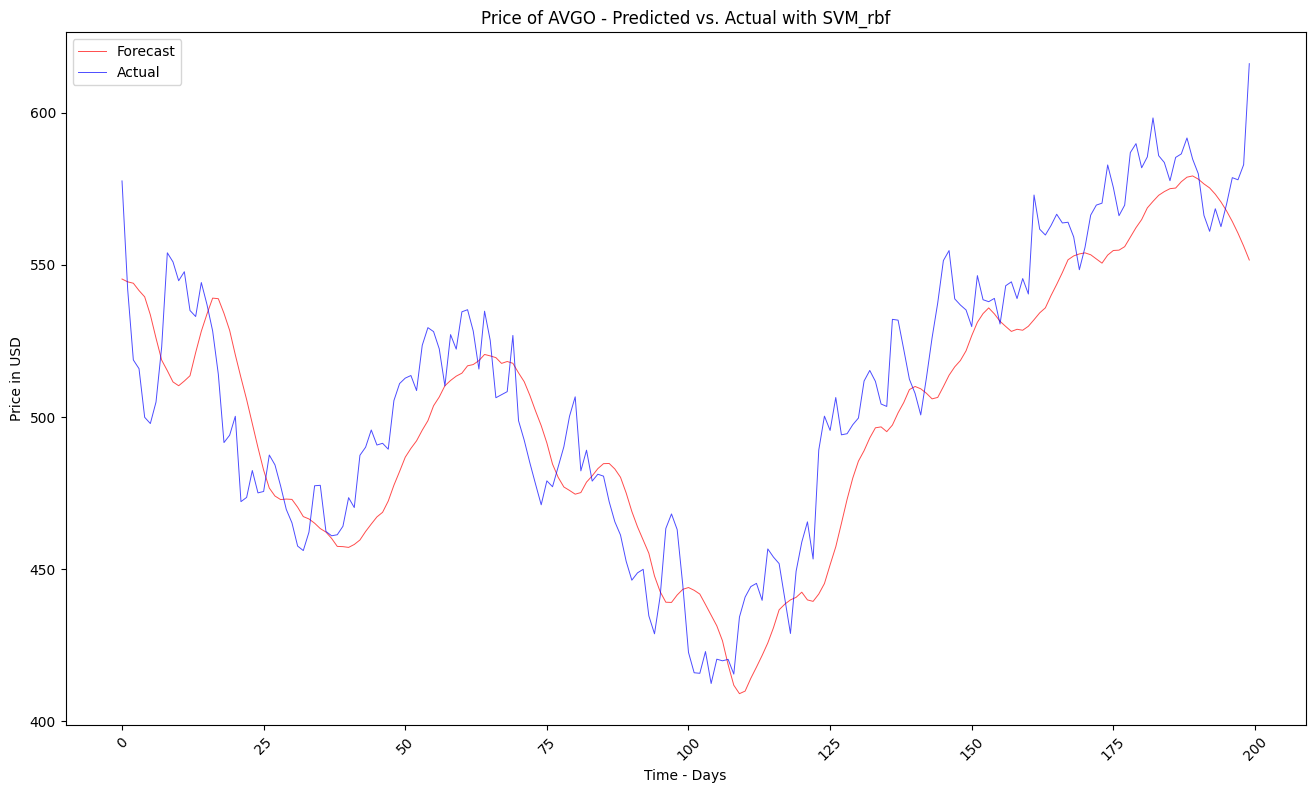

SVM model confidence score for AMD: 0.9295317141583804
Mean Absolute Error for AMD: 5.252784451862971
Mean Squared Error for AMD: 47.571228788361566
R2 Score for AMD: 0.9002271303214141


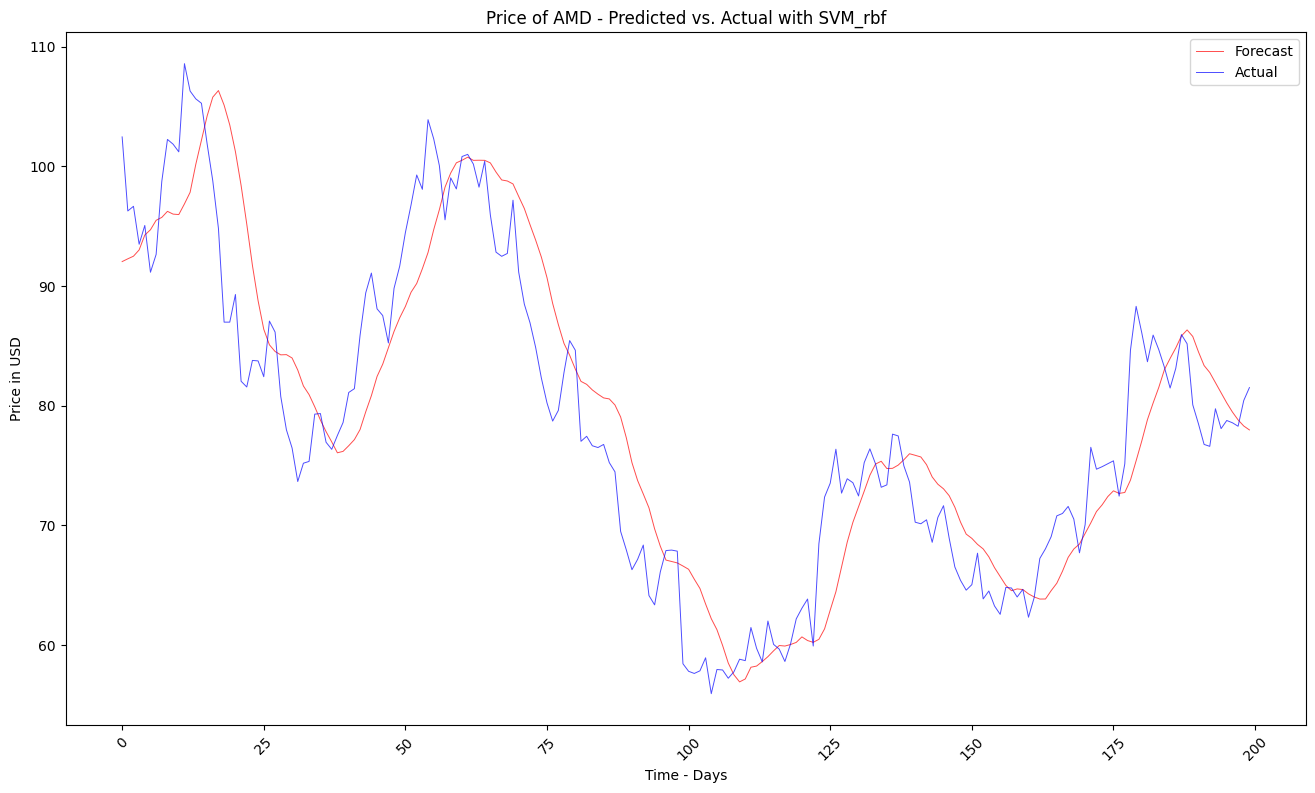

SVM model confidence score for LLY: 0.9203030932030315
Mean Absolute Error for LLY: 8.295384336363396
Mean Squared Error for LLY: 115.50247530056402
R2 Score for LLY: 0.9720326540700662


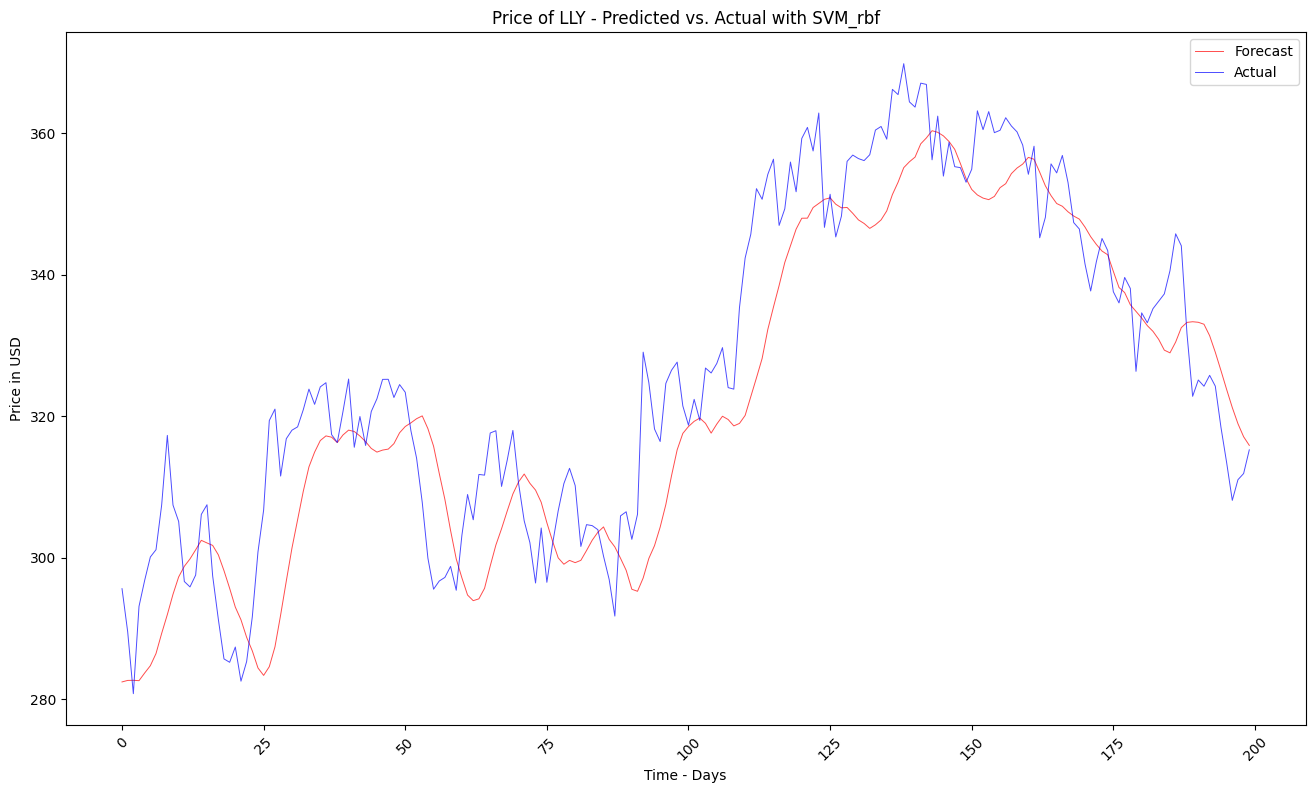

SVM model confidence score for PFE: 0.9453496598637176
Mean Absolute Error for PFE: 1.2343867208228974
Mean Squared Error for PFE: 2.7517936870493585
R2 Score for PFE: 0.9334180702449666


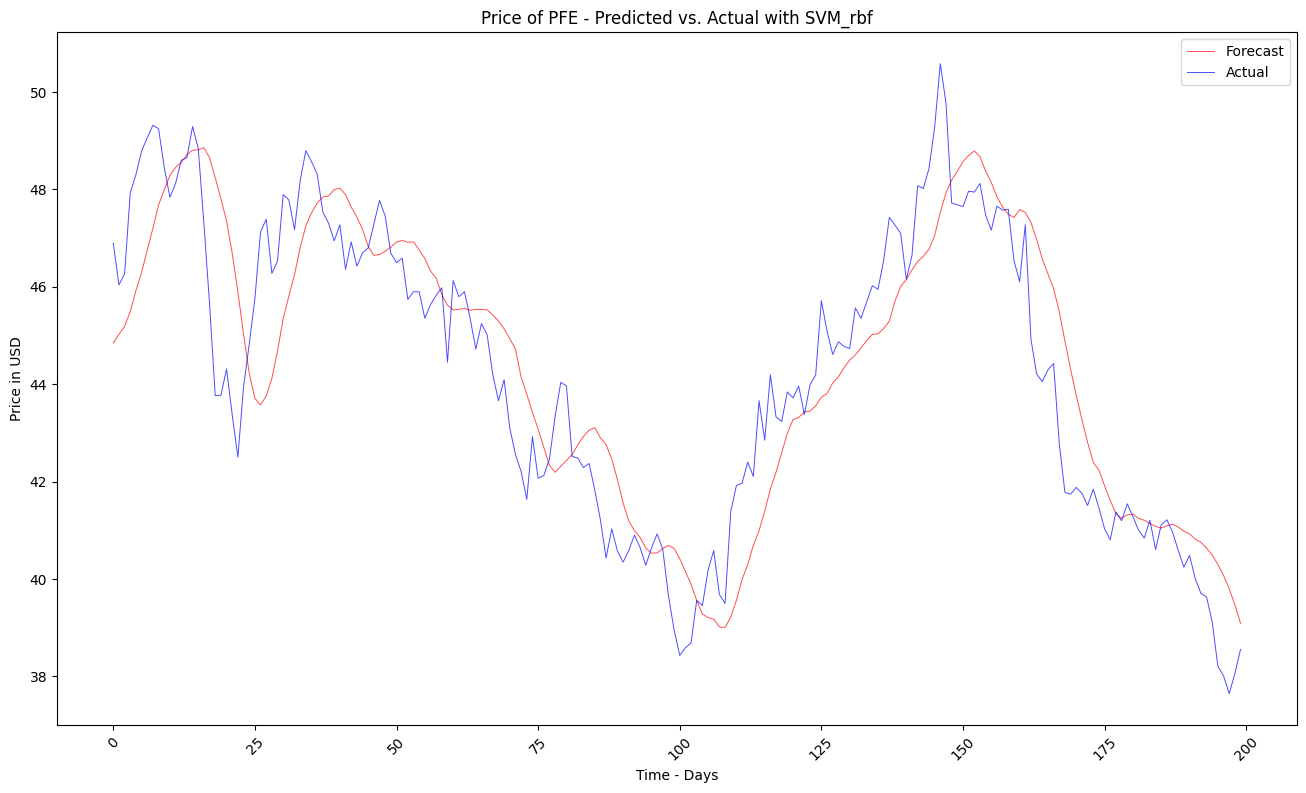

SVM model confidence score for BRK-B: 0.9418194634492808
Mean Absolute Error for BRK-B: 6.057625538634839
Mean Squared Error for BRK-B: 63.76416645169634
R2 Score for BRK-B: 0.9372949005767744


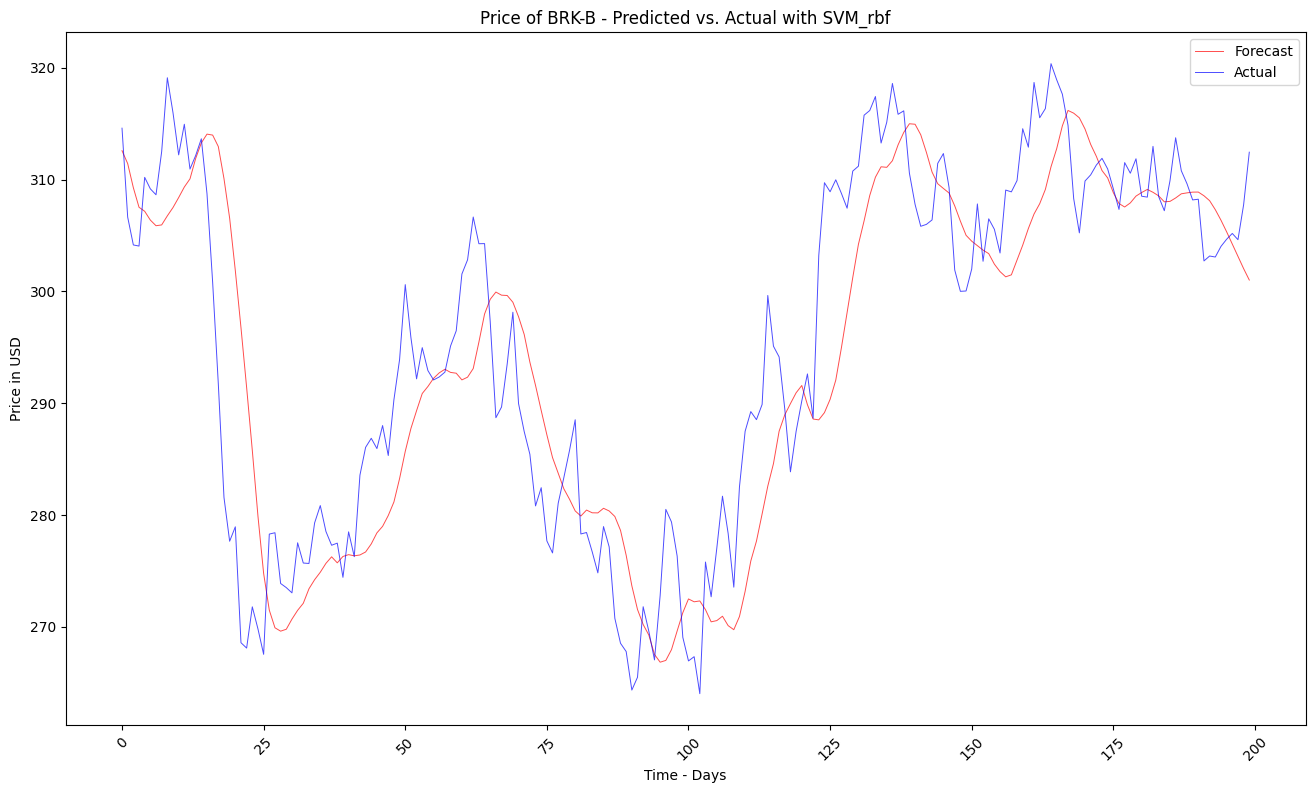

SVM model confidence score for BLK: 0.8633014645255188
Mean Absolute Error for BLK: 24.348869478774933
Mean Squared Error for BLK: 923.5762221524044
R2 Score for BLK: 0.8993182500578331


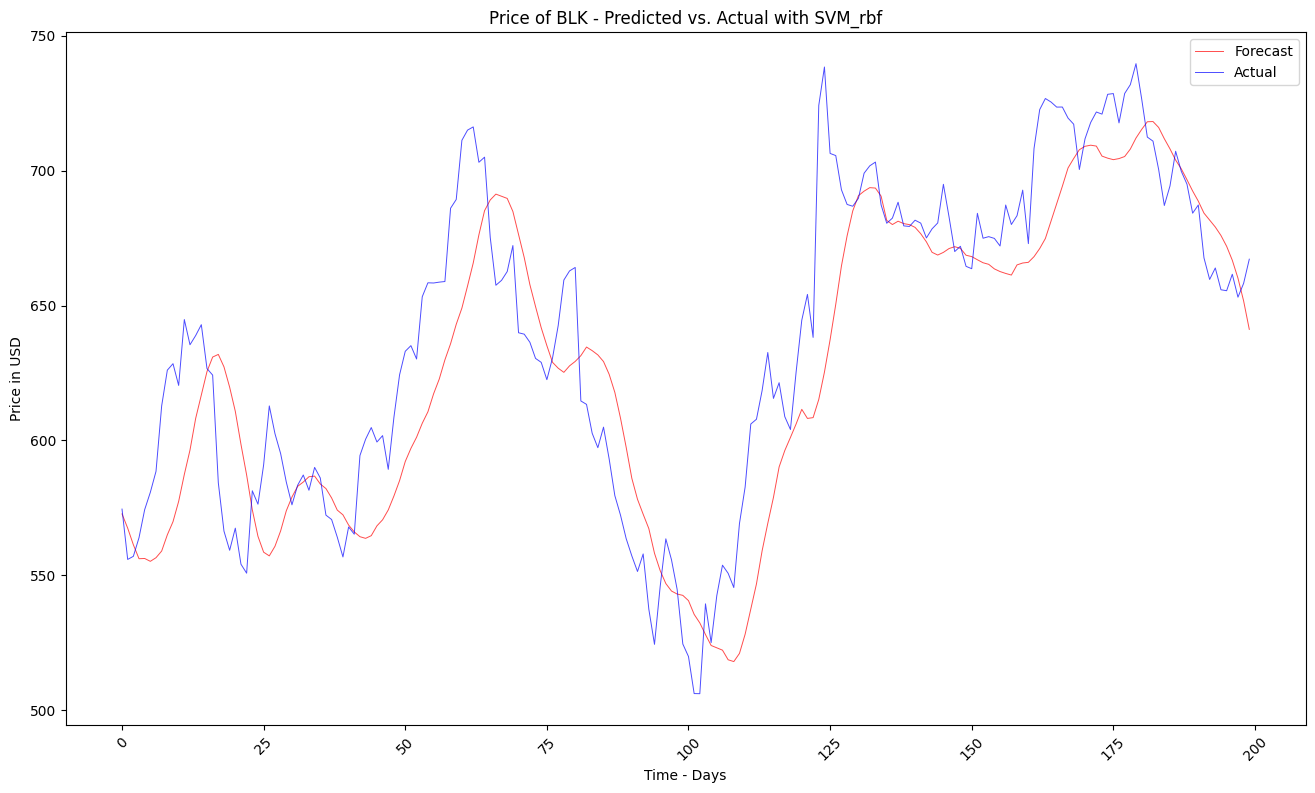

In [33]:
for df in adj_close_forecasts:

    feature_array = np.array(df.iloc[:, 0])
    feature_array = feature_array[:df.shape[0] - FORECAST_DAYS]
    feature_array = np.reshape(feature_array, (-1, 1))
    
    target_array = np.array(df.iloc[:, 1])
    target_array = target_array[:-FORECAST_DAYS]    

    #Divido i dati in set di training, validazione e test
    X_training = feature_array[:1600]
    y_training = target_array[:1600]
    X_validation = feature_array[1600:2200]
    y_validation = target_array[1600:2200]
    X_test = feature_array[2200:]
    y_test = target_array[2200:]

    #Standardizzazione dei dati
    scaler = StandardScaler()
    scaler.fit(X_training)
    x_training = scaler.transform(X_training)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    #Training del modello SVM
    svm_model = SVR(kernel='rbf', C = 1e3, gamma = 0.0001)
    svm_model.fit(x_training, y_training)

    #Valutazione del modello
    svm_model_confidence = svm_model.score(X_test, y_test)
    print(f'SVM model confidence score for {df.columns[0]}: {svm_model_confidence}')

    #Affinamento delle predizioni
    svm_predictions = svm_model.predict(X_test)
    svm_prediction_smooth = savgol_filter(svm_predictions, 15, 3)

    svm_val_predictions = svm_model.predict(X_validation)
    svm_val_predictions_smooth = savgol_filter(svm_val_predictions, 15, 3)

    #calcolo metriche di valutazione
    mae = mean_absolute_error(y_validation, svm_val_predictions)
    mse = mean_squared_error(y_validation, svm_val_predictions)
    r2 = r2_score(y_validation, svm_val_predictions)

    print(f'Mean Absolute Error for {df.columns[0]}: {mae}')
    print(f'Mean Squared Error for {df.columns[0]}: {mse}')
    print(f'R2 Score for {df.columns[0]}: {r2}')

    #Grafico dei risultati
    plt.figure(figsize=(16,9))
    plt.plot(svm_val_predictions_smooth[400:], label = 'Forecast', linewidth = '0.7', color ='r', alpha = .7)
    plt.plot(y_validation[400:], label = 'Actual', linewidth = '0.7', color ='b', alpha = .7)
    plt.title('Price of ' f"{df.columns[0]}" ' - Predicted vs. Actual with SVM_rbf')
    plt.ylabel('Price in USD')
    plt.xlabel('Time - Days')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

### Utilizzo stile ggplot

In [34]:
style.use('ggplot')

### Scarico i dati dei ticker in DataFrame separati

In [35]:
stock_dataframes = {}

for ticker in selected_stocks:
    stock_data = yf.download(ticker, start=START_DATE, end=END_DATE)
    stock_data = stock_data.drop(columns=['High', 'Low', 'Open', 'Close'])
    stock_dataframes[f"df_{ticker}"] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Creo le due serie mobili

In [36]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_dataframes[dataframe_key]['SMA20'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(20).mean()
    stock_dataframes[dataframe_key]['SMA120'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(120).mean()

### Mostro un grafico per ogni azione

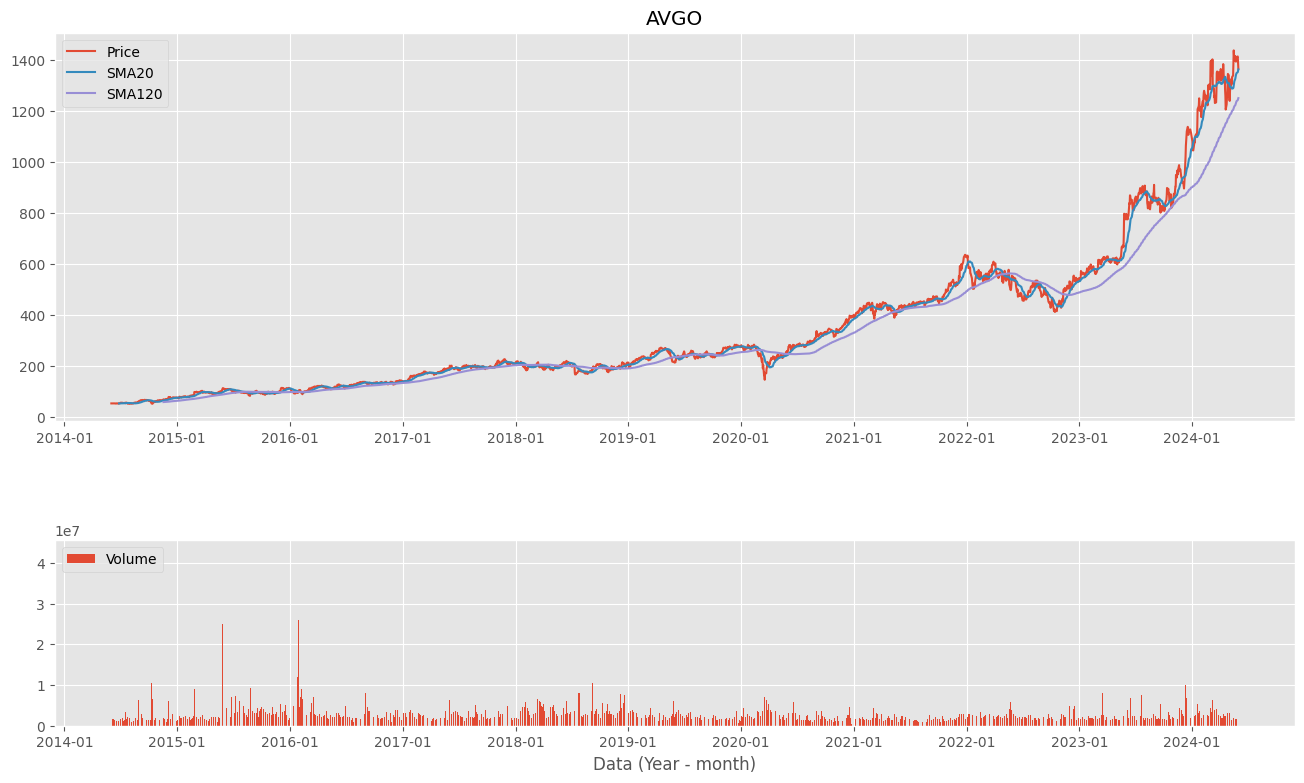

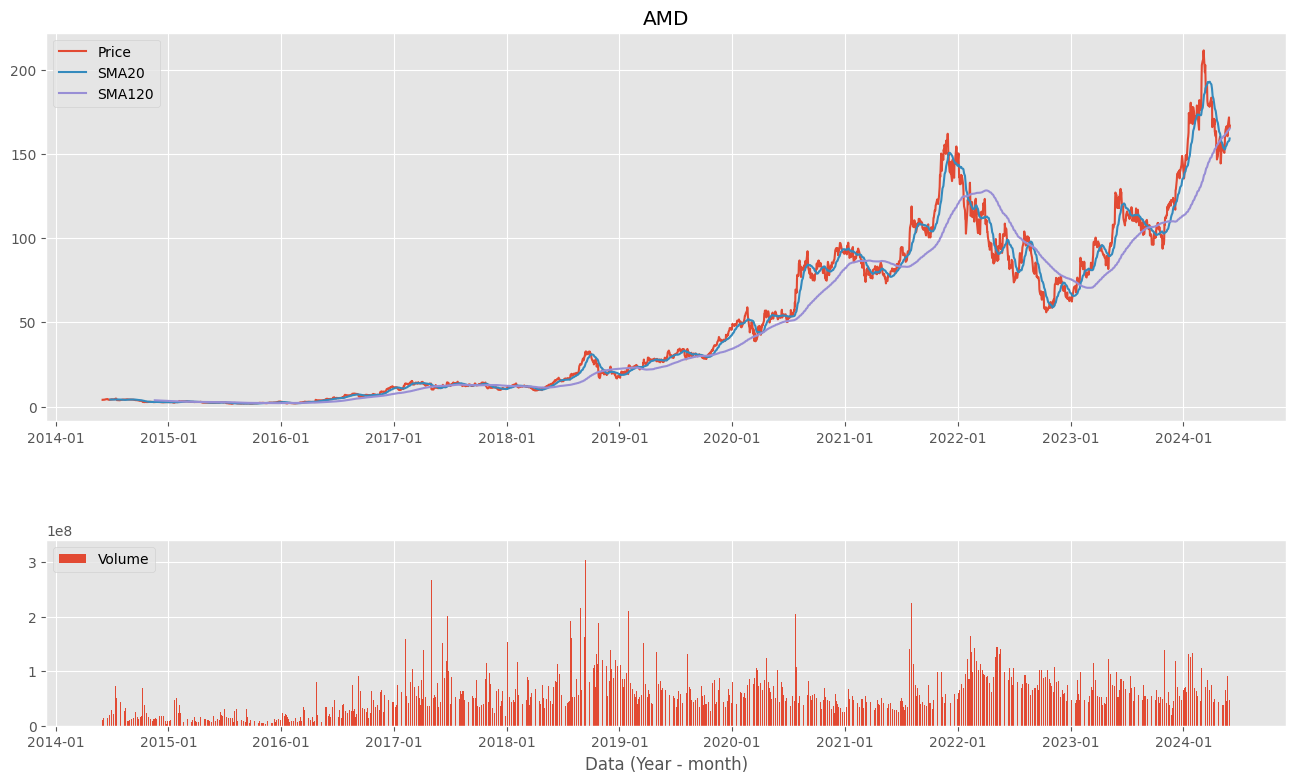

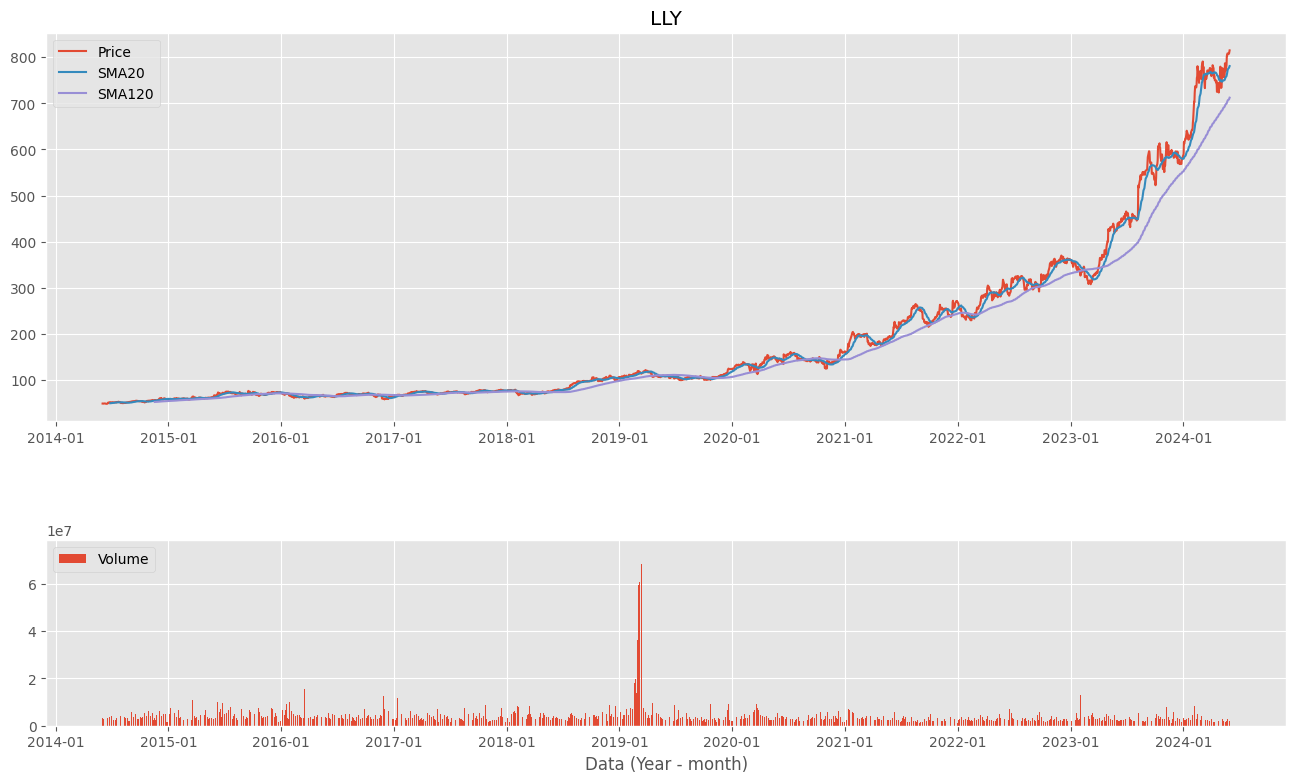

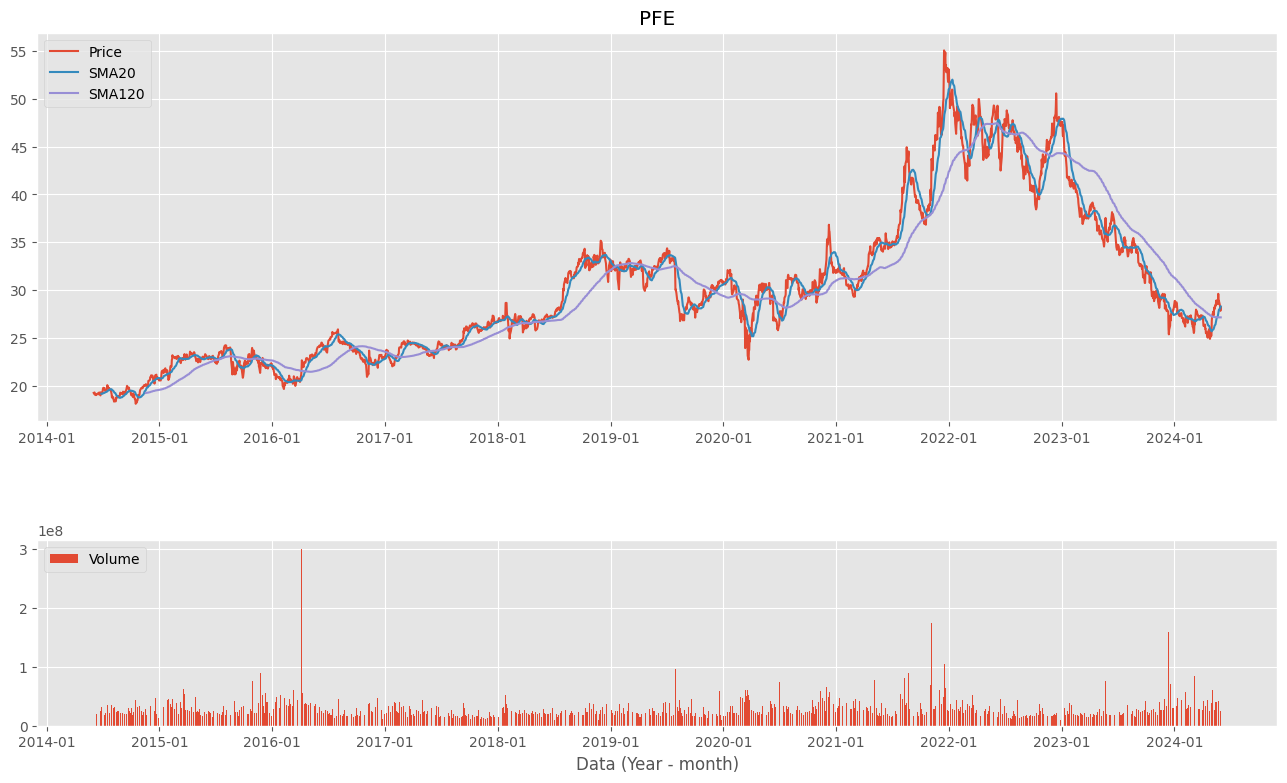

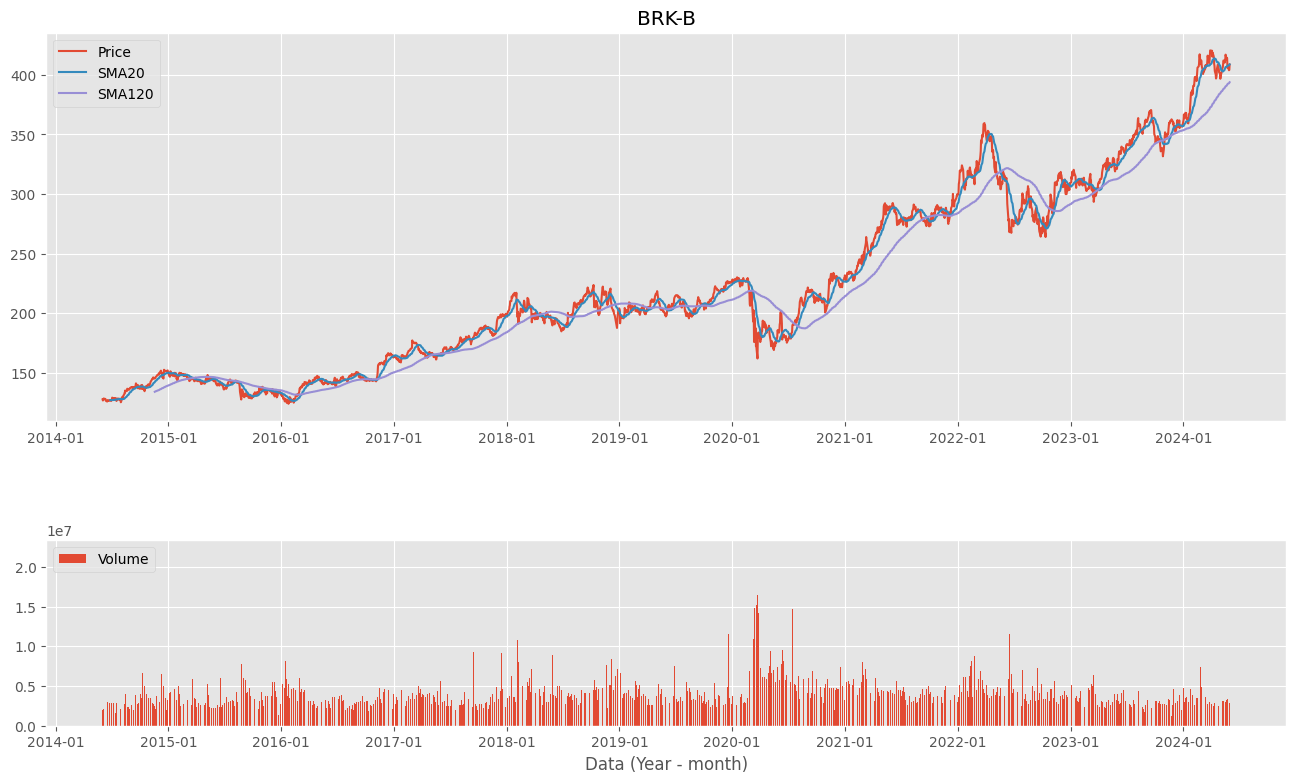

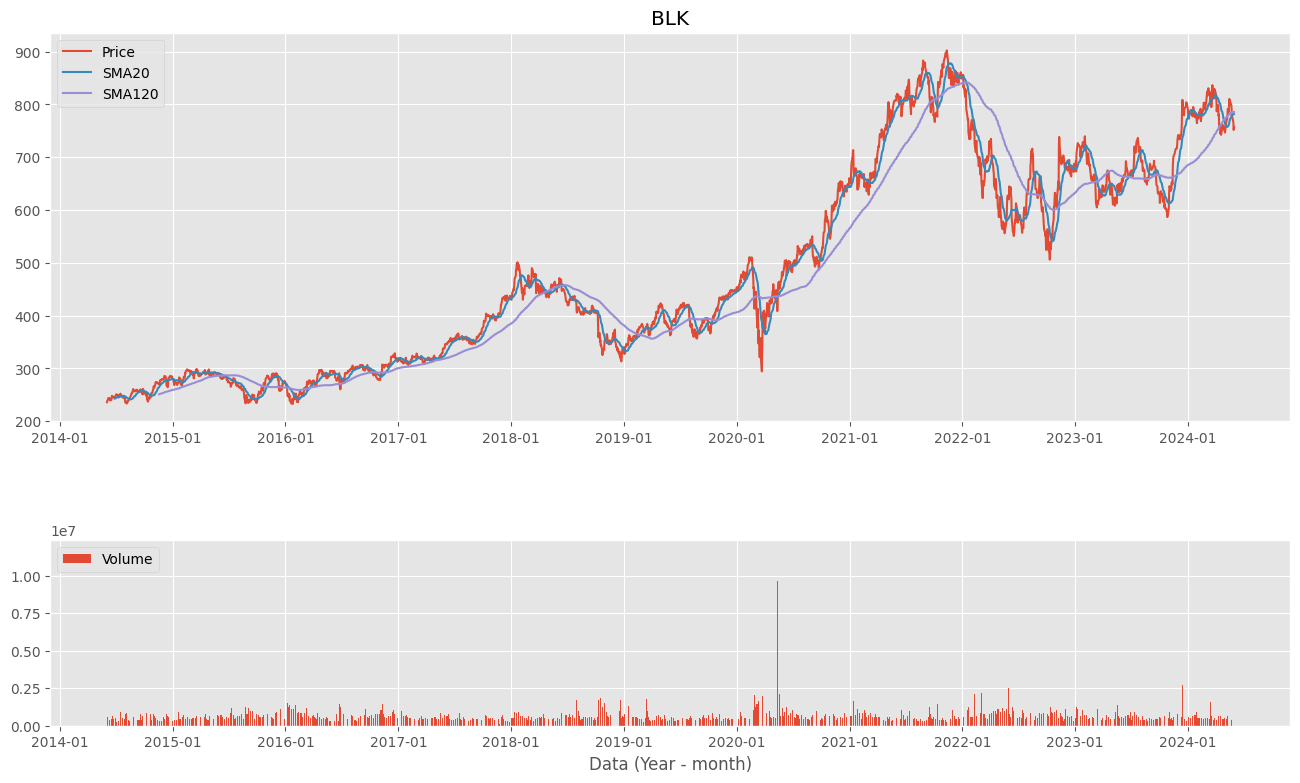

In [37]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((7, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((7, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_df['Adj Close'], label='Price')
    ax1.plot(stock_df['SMA20'], label='SMA20')
    ax1.plot(stock_df['SMA120'], label='SMA120')

    ax2.bar(stock_df.index, stock_df['Volume'], label='Volume')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax2.set_xlabel('Data (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.show()

### Implemento la strategia e rendimenti

In [38]:
sma_data = {}

for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    stock_df['Price_Yesterday'] = stock_df['Adj Close'].shift(1)
    stock_df['Change'] = stock_df['Adj Close'] / stock_df['Price_Yesterday']
    stock_df['Invested_SMA'] = stock_df.apply(
        lambda row: 1 if row['SMA20'] > row['SMA120'] else 0, axis=1
    )

    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = stock_df[stock_df['Invested_SMA'] == 1]

### Calcolo il prodotto cumulativo

In [39]:
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = sma_data[sma_key].copy()
    sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)

### Calcolo ritorno medio, volatilita' annualizzata e Sharpe ratio

In [40]:
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = sma_data[sma_key].copy()
    sma_data[sma_key].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
    sma_data[sma_key].loc[:, 'annual_volatility'] = sma_data[sma_key].loc[:, 'rtn'].std()*np.sqrt(252)
    sma_data[sma_key].loc[:, 'sharpe_ratio'] = sma_data[sma_key].loc[:, 'rtn'].mean()*252 / (sma_data["sma_" + ticker]['rtn'].std()*np.sqrt(252))

# Mostro un ticker di esempio
sma_data["sma_AVGO"]

Adj Close   Volume        SMA20       SMA120  Price_Yesterday  \
Date                                                                          
2014-11-18    70.056999  2002500    65.526794    59.796919        67.842110   
2014-11-19    68.401581  1876300    65.848302    59.912920        70.056999   
2014-11-20    68.922722  1512100    66.175940    60.034467        68.401581   
2014-11-21    69.137329  1746100    66.496296    60.156789        68.922722   
2014-11-24    69.850090  1187600    66.863021    60.283402        69.137329   
...                 ...      ...          ...          ...              ...   
2024-05-23  1393.290039  3103900  1343.982507  1233.163567      1392.239990   
2024-05-24  1407.839966  1672100  1347.171008  1237.213755      1393.290039   
2024-05-28  1412.449951  2291900  1350.862506  1241.352167      1407.839966   
2024-05-29  1390.670044  2686100  1355.382507  1245.398701      1412.449951   
2024-05-30  1364.079956  2172800  1361.443506  1249.301956      1390.670044   

              Change  Invested_SMA    Return       rtn  annual_volatility  \
Date                                                                        
2014-11-18  1.032648             1  1.032648       NaN           0.313716   
2014-11-19  0.976370             1  1.008247 -0.023630           0.313716   
2014-11-20  1.007619             1  1.015928  0.007619           0.313716   
2014-11-21  1.003114             1  1.019092  0.003114           0.313716   
2014-11-24  1.010309             1  1.029598  0.010309           0.313716   
...              ...           ...       ...       ...                ...   
2024-05-23  1.000754             1  9.772087  0.000754           0.313716   
2024-05-24  1.010443             1  9.874136  0.010443           0.313716   
2024-05-28  1.003275             1  9.906469  0.003275           0.313716   
2024-05-29  0.984580             1  9.753712 -0.015420           0.313716   
2024-05-30  0.980880             1  9.567217 -0.019120           0.313716   

            sharpe_ratio  
Date                      
2014-11-18      1.123267  
2014-11-19      1.123267  
2014-11-20      1.123267  
2014-11-21      1.123267  
2014-11-24      1.123267  
...                  ...  
2024-05-23      1.123267  
2024-05-24      1.123267  
2024-05-28      1.123267  
2024-05-29      1.123267  
2024-05-30      1.123267  

[1851 rows x 11 columns]

### Calcolo il rendimento con strategia "Buy and Hold"

In [41]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_data = stock_dataframes[dataframe_key]
    stock_data['Buy_and_hold'] = np.cumprod(stock_data['Change'])

### Confronto i rendimenti

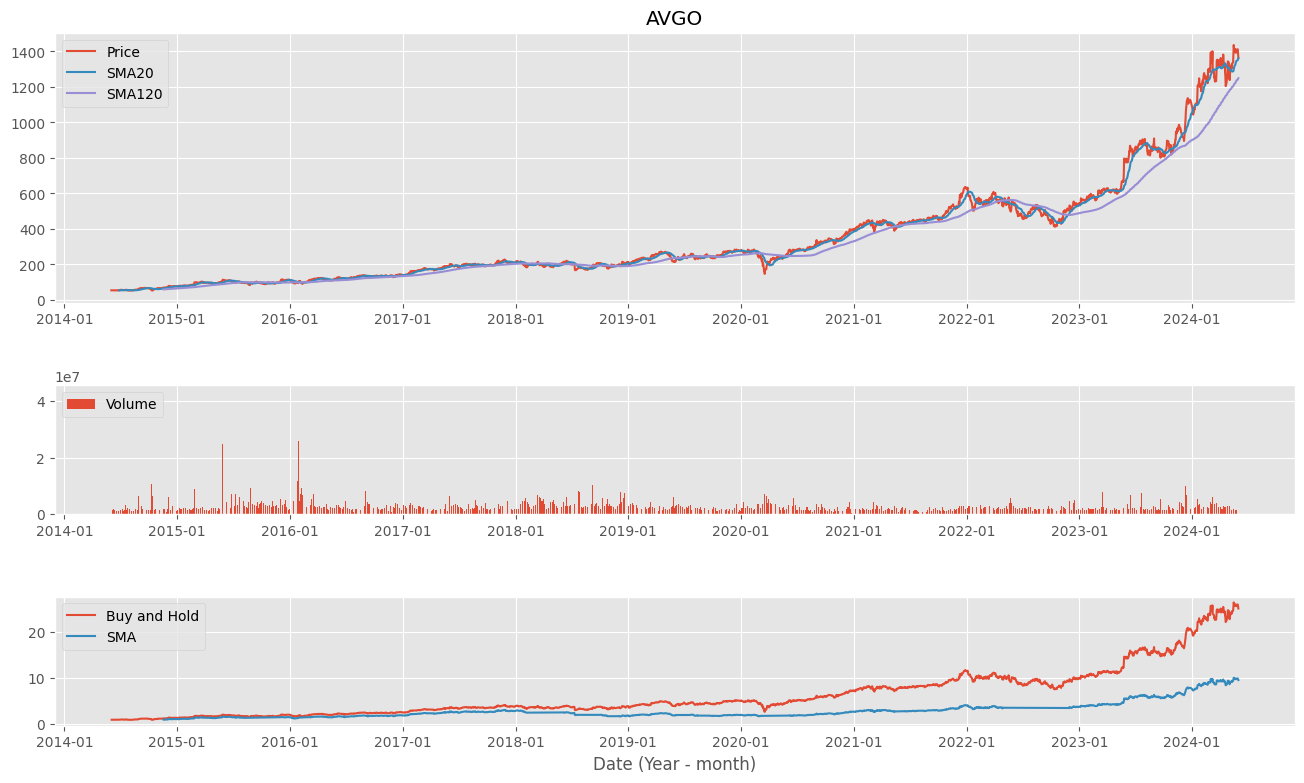

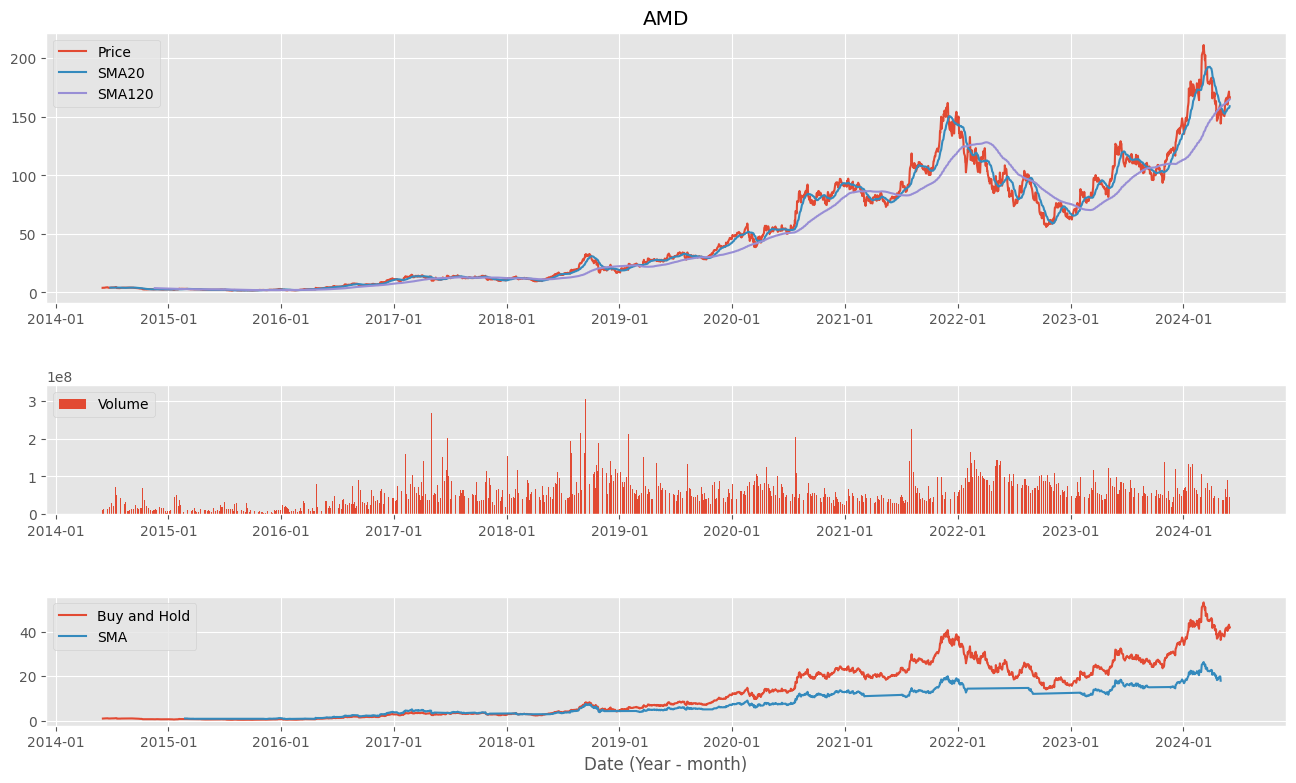

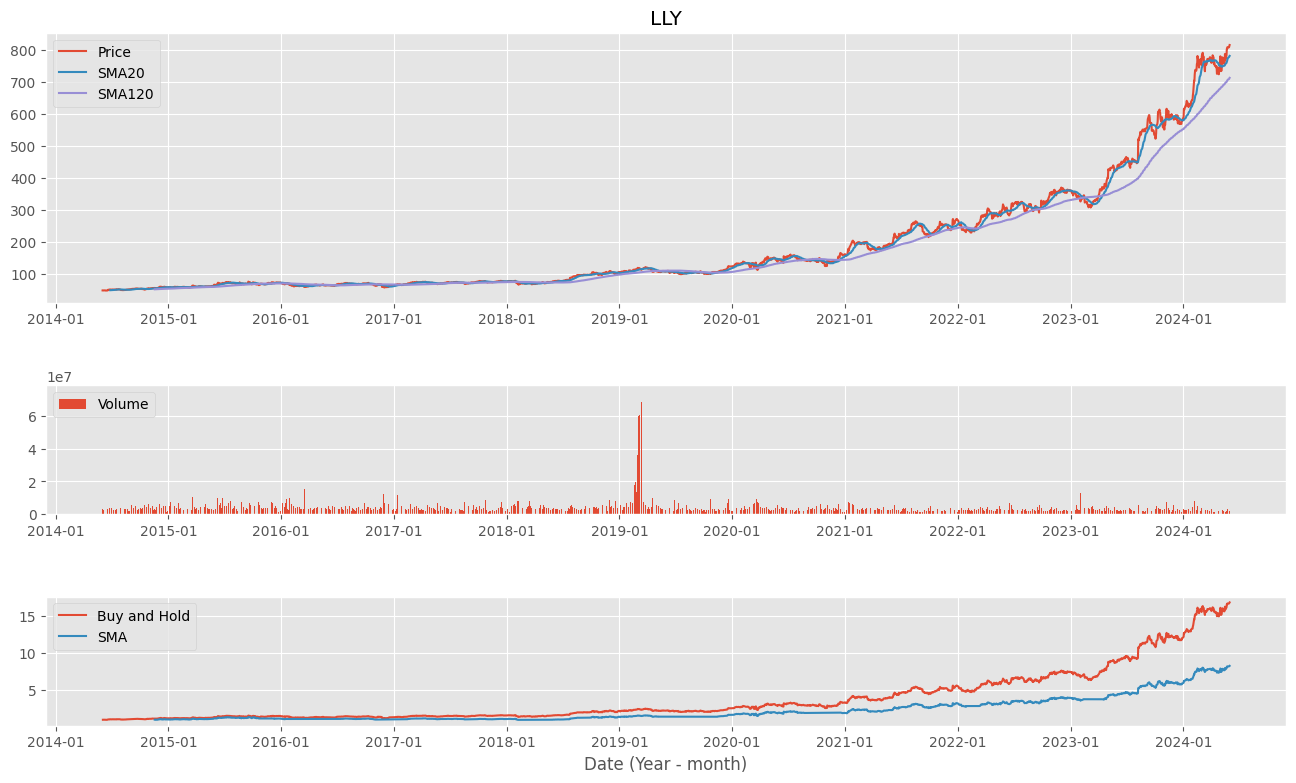

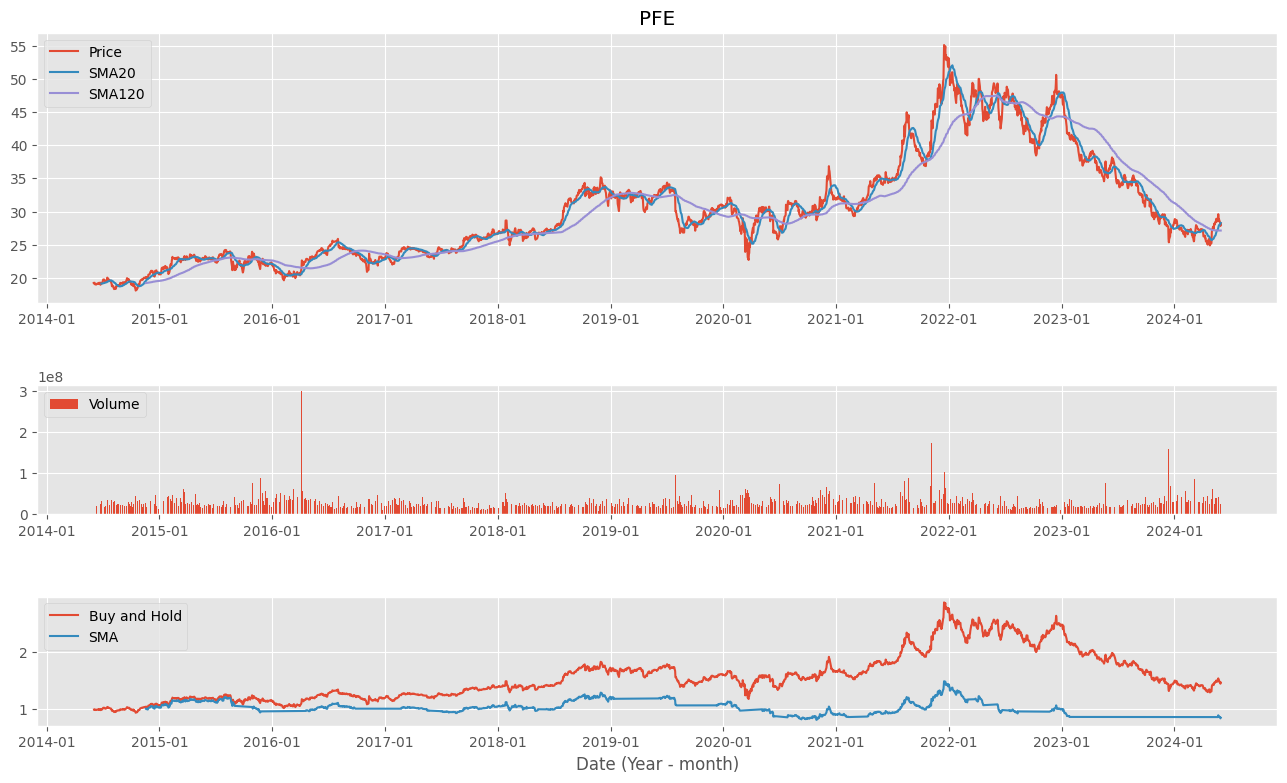

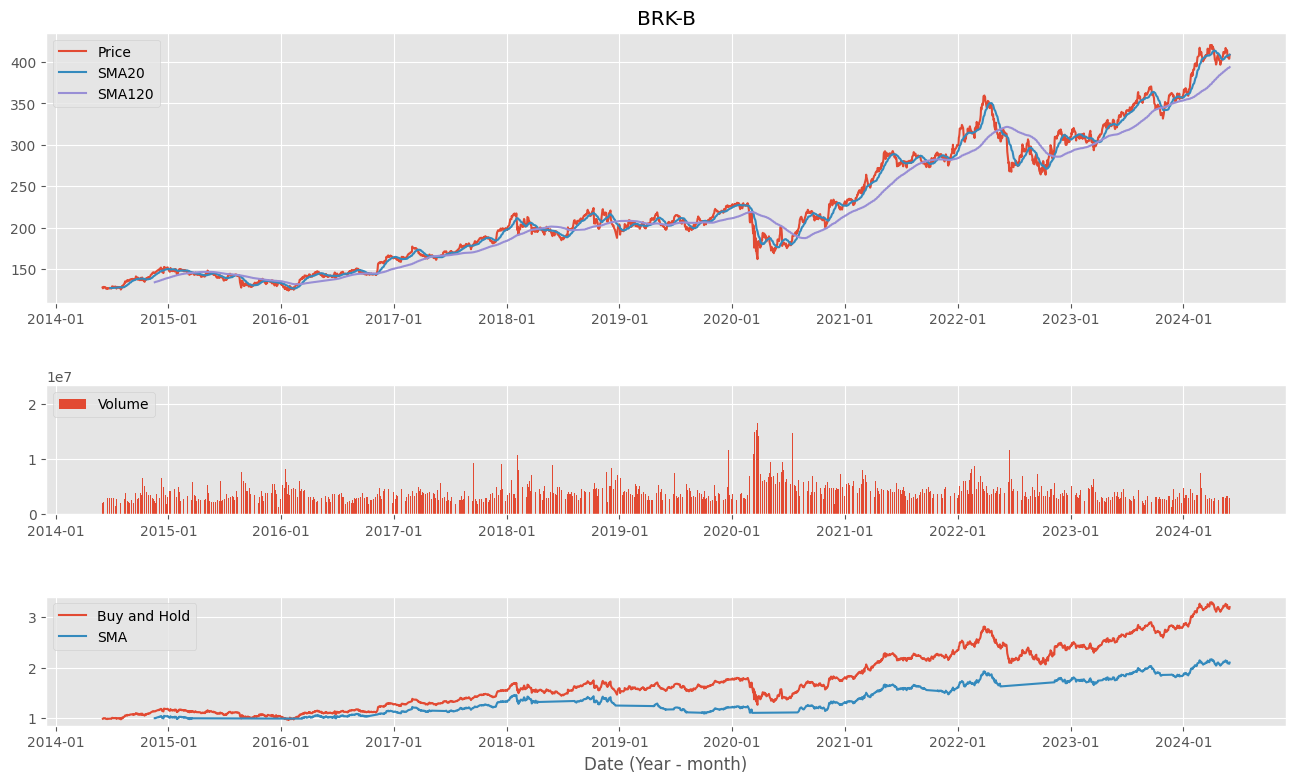

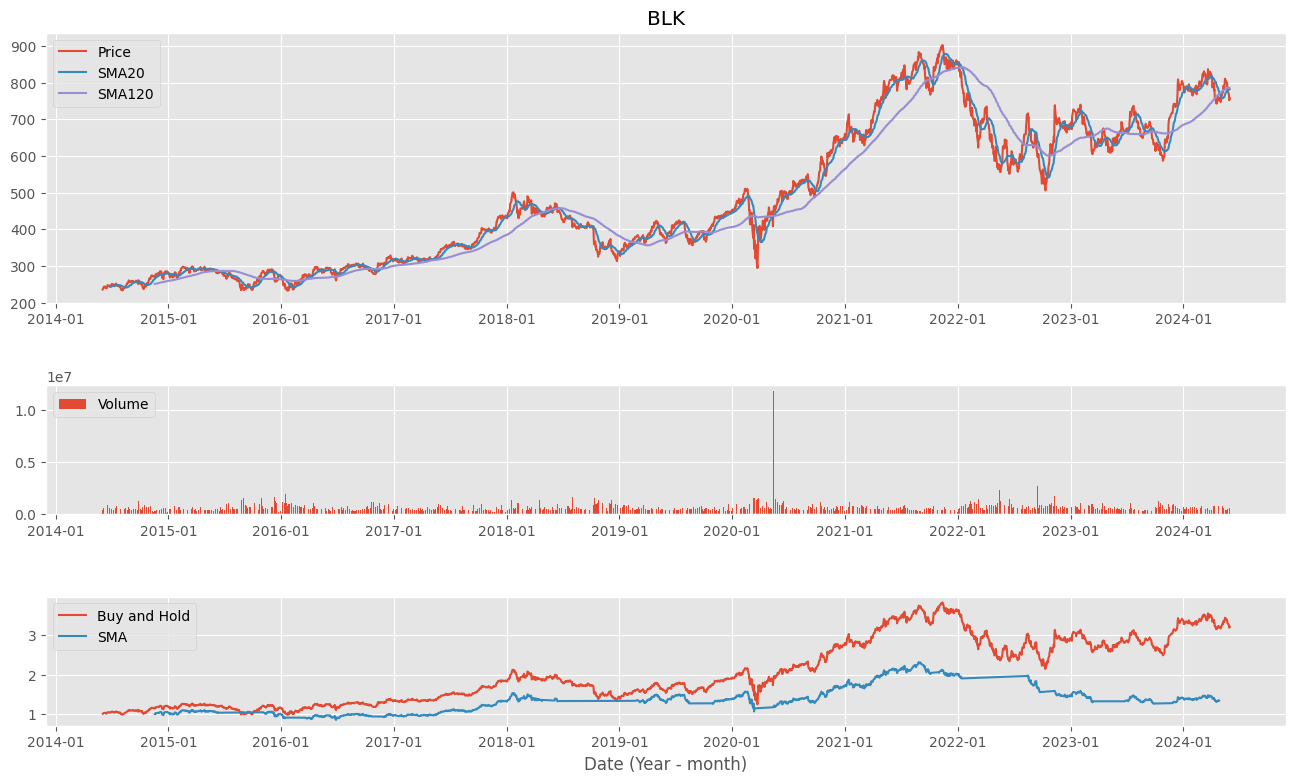

In [42]:
for ticker in selected_stocks:
    stock_data = stock_dataframes[f"df_{ticker}"]
    stock_sma_data = sma_data[f"sma_{ticker}"]


    plt.figure(figsize=(16,9))

    ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10, 1), (8, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_data['Adj Close'], label='Price')
    ax1.plot(stock_data['SMA20'], label='SMA20')
    ax1.plot(stock_data['SMA120'], label='SMA120')

    ax2.bar(stock_data.index, stock_data['Volume'], label='Volume')

    ax3.plot(stock_data['Buy_and_hold'], label='Buy and Hold')
    ax3.plot(stock_sma_data['Return'], label='SMA')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    plt.show()

### Download dei dataframe con il benchmark di mercato e benchmark risk-free

In [43]:
MARKET_BENCHMARK = '^GSPC'
RISK_FREE_RATE = '^IRX'

capm_data = {}

for ticker in selected_stocks:
    dataframe_key = f"capm_{ticker}"
    capm_data[dataframe_key] = yf.download([ticker, MARKET_BENCHMARK, RISK_FREE_RATE], start=START_DATE, end=END_DATE)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


### Calcolo di beta rispetto al benchmark di mercato

In [44]:
assets_beta = {}

for ticker in selected_stocks:
    beta_key = f'beta_{ticker}'
    
    capm_data_key = f'capm_{ticker}'
    capm_data_df = capm_data[capm_data_key]['Adj Close']
    capm_data_df = capm_data_df.rename(columns={ticker: 'asset', MARKET_BENCHMARK: 'market', RISK_FREE_RATE: 'risk_free'})
    
    capm_data_df = capm_data_df.resample('ME').mean()
    capm_data_df['mrf'] = (1 + capm_data_df['risk_free'] / 100)**(30 / 360) - 1
    capm_data_df['asset_nmr'] = capm_data_df['asset'].pct_change() - capm_data_df['mrf']
    capm_data_df['market_nmr'] = capm_data_df['market'].pct_change() - capm_data_df['mrf']

    capm_data_df.dropna(inplace=True)
    
    regression_df = capm_data_df[['asset_nmr', 'market_nmr']]
    covariance = regression_df.cov().iloc[0, 1]
    market_variance = regression_df['market_nmr'].var()
    assets_beta[beta_key] = covariance / market_variance

    y = regression_df.pop('asset_nmr')
    X = sm.add_constant(regression_df)

    model = sm.OLS(y, X).fit()
    
    print('\n' + ticker + '\n')
    print(model.summary())

for asset,beta in assets_beta.items():
    print(f"{asset}: {beta}")


AVGO

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     62.97
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.41e-12
Time:                        17:46:26   Log-Likelihood:                 172.79
No. Observations:                 119   AIC:                            -341.6
Df Residuals:                     117   BIC:                            -336.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.005      3.583  

### Scarico i Data Factors

In [45]:
FF_DATA_URL = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

urllib.request.urlretrieve(FF_DATA_URL,'fama_french.zip')

with zipfile.ZipFile('fama_french.zip', 'r') as zip_ref:
    zip_ref.extractall()

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

#Filtro i dati
SEARCH_STRING = ' Annual Factors: January-December '
matching_indices = factor_df.iloc[:, 0] == SEARCH_STRING
start_of_annual_index = factor_df[matching_indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual_index]

#Rinomino e formatto le colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

### Scarico i DataFrames per Fama-French

In [46]:
fama_french_data = {}

for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    fama_french_data[dataframe_key] = yf.download(ticker, start=START_DATE, end=END_DATE)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Filtro la tabella con START_DATE e END_DATE

In [47]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[START_DATE:END_DATE]
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

### Strima del modello a tre fattori

In [48]:
for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    
    stock_returns = fama_french_data[dataframe_key]['Adj Close'].resample('ME').last().pct_change().dropna()
    
    stock_returns.index = stock_returns.index.strftime('%Y-%m')
    stock_returns.name = 'rtn'

    ff_data = factor_df.join(stock_returns)
    
    ff_data['excess_rtn'] = ff_data['rtn'] - ff_data['rf']

    average_risk_free_rate = ff_data['rf'].mean()
    average_market_premium = ff_data['mkt'].mean()

    ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()
    
    print('\n' + ticker + '\n')
    print(ff_model.summary())


AVGO

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     19.92
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.88e-10
Time:                        17:46:29   Log-Likelihood:                 149.73
No. Observations:                 118   AIC:                            -291.5
Df Residuals:                     114   BIC:                            -280.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0197      0.007      2.999  

### Calcolo i rendimenti attesi per ogni asset con CAPM

In [49]:
predicted_returns = {}

for ticker in selected_stocks:
    return_key = f"rtn_{ticker}"

    expected_return = average_risk_free_rate + (assets_beta[f'beta_{ticker}'] * average_market_premium)
    annualized_expected_return = expected_return * 12
    predicted_returns[return_key] = annualized_expected_return
    print(f"{ticker}: {annualized_expected_return}")

AVGO: 0.14871095411080015
AMD: 0.25222311526498586
LLY: 0.05058274054696581
PFE: 0.08653162914445876
BRK-B: 0.10227395832616595
BLK: 0.18240569145591617


### Scarico i prezzi e le impostazioni per il portafoglio

In [50]:
NUMBER_OF_PORTFOLIOS = 10000
TRADING_DAYS_PER_YEAR = 252
PORTFOLIO_START_DATE = '2014-05-31'
PORTFOLIO_END_DATE = '2023-05-31'

portfolio_data = yf.download(selected_stocks, start=PORTFOLIO_START_DATE, end=PORTFOLIO_END_DATE)

[*********************100%%**********************]  6 of 6 completed


In [51]:
returns_df = portfolio_data['Adj Close'].pct_change().dropna()
annualized_avg_returns = returns_df.mean() * TRADING_DAYS_PER_YEAR
annualized_covariance_matrix = returns_df.cov() * TRADING_DAYS_PER_YEAR

### Definisco la funzione per calcolare il rendimento e la varianza di un portafoglio

In [52]:
def calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix):
    """
    Calcola il rendimento atteso e la varianza di un portafoglio.

    Parametri:
    weights (np.ndarray): Un array di pesi per ciascun asset nel portafoglio.
                          I pesi dovrebbero sommare a 1.
    expected_returns (np.ndarray): Un array di rendimenti attesi per ciascun asset.
    covariance_matrix (np.ndarray): Una matrice 2D che rappresenta la matrice di covarianza dei rendimenti degli asset.

    Restituisce:
    tuple: Una tupla che contiene:
        - portfolio_return (float): Il rendimento atteso del portafoglio.
        - portfolio_variance (float): La varianza del portafoglio.

    Esempio:
    >>> weights = np.array([0.4, 0.6])
    >>> expected_returns = np.array([0.1, 0.2])
    >>> covariance_matrix = np.array([[0.005, -0.010], [-0.010, 0.040]])
    >>> calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)
    (0.16, 0.0084)

    Note:
    - Assicurarsi che il numero di elementi in 'weights' corrisponda al numero di asset.
    - L'array 'expected_returns' deve avere la stessa lunghezza dell'array 'weights'.
    - La 'covariance_matrix' deve essere una matrice quadrata con dimensioni pari alla lunghezza dell'array 'weights'.

    """
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    return portfolio_return, portfolio_variance

### Definisco la funzione per generare portafogli casuali

In [53]:
def monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios):
    """
    Esegue una simulazione Monte Carlo per generare diverse combinazioni di portafogli e calcola il rendimento atteso,
    la varianza e il rapporto Sharpe per ciascun portafoglio.

    Parametri:
    expected_returns (np.ndarray): Un array di rendimenti attesi per ciascun asset.
    covariance_matrix (np.ndarray): Una matrice 2D che rappresenta la matrice di covarianza dei rendimenti degli asset.
    num_portfolios (int): Il numero di portafogli da generare nella simulazione.

    Restituisce:
    tuple: Una tupla che contiene:
        - portfolio_results (np.ndarray): Un array 2D di dimensioni (3, num_portfolios) contenente:
            - rendimento atteso per ciascun portafoglio (portfolio_results[0])
            - varianza per ciascun portafoglio (portfolio_results[1])
            - rapporto Sharpe per ciascun portafoglio (portfolio_results[2])
        - portfolio_random_weights (list): Una lista di array di pesi generati casualmente per ciascun portafoglio.

    Esempio:
    >>> expected_returns = np.array([0.1, 0.2])
    >>> covariance_matrix = np.array([[0.005, -0.010], [-0.010, 0.040]])
    >>> num_portfolios = 10000
    >>> monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios)
    (array([[...], [...], [...]]), [array([...]), array([...]), ...])

    Note:
    - Assicurarsi che il numero di elementi in 'expected_returns' corrisponda al numero di asset.
    - La 'covariance_matrix' deve essere una matrice quadrata con dimensioni pari alla lunghezza dell'array 'expected_returns'.
    - Il numero di portafogli 'num_portfolios' dovrebbe essere sufficientemente grande per ottenere risultati significativi.

    """
    num_assets = len(expected_returns)
    portfolio_results = np.zeros((3, num_portfolios))
    portfolio_random_weights = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_random_weights.append(weights)

        portfolio_return, portfolio_variance = calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)

        portfolio_results[0, i] = portfolio_return
        portfolio_results[1, i] = portfolio_variance
        portfolio_results[2, i] = portfolio_return / np.sqrt(portfolio_variance)

    return portfolio_results, portfolio_random_weights

### Genero i risultati e i pesi casuali

In [54]:
results, random_weights = monte_carlo_simulation(annualized_avg_returns, annualized_covariance_matrix, NUMBER_OF_PORTFOLIOS)

### Calcolo i valori migliori

In [55]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti passati

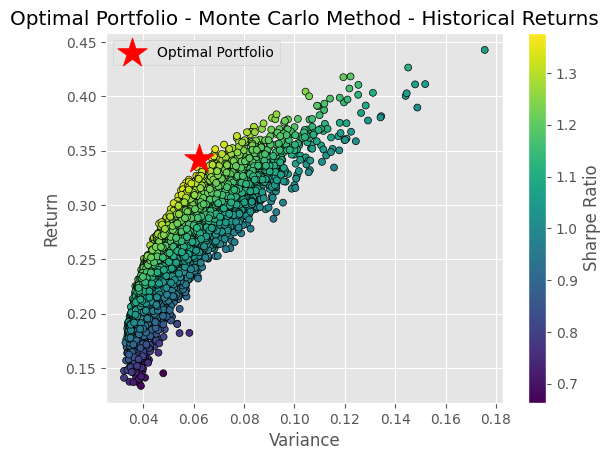

In [56]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Historical Returns')

plt.legend()

plt.show()

### Converto il dizionario in lista e successivamente in array Numpy

In [57]:
expected_returns = np.array(list(predicted_returns.values()))
asset_betas = np.array(list(assets_beta.values()))

### Genero i risultati e i pesi casuali

In [58]:
results, random_weights = monte_carlo_simulation(expected_returns, annualized_covariance_matrix, NUMBER_OF_PORTFOLIOS)

### Calcolo i valori migliori

In [59]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti previsti

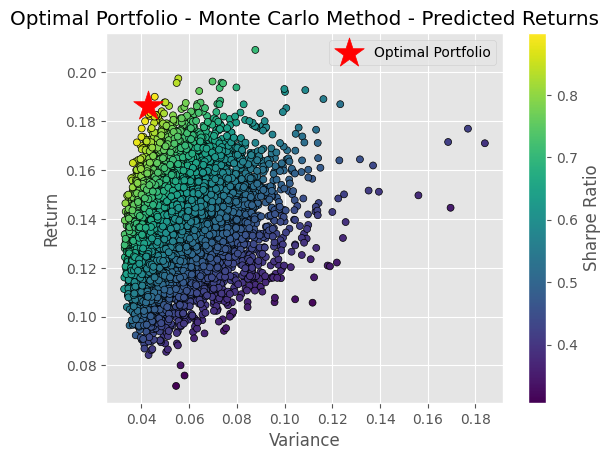

In [60]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Predicted Returns')

plt.legend()

plt.show()

### Calcolo il Beta del portafoglio ottimale

In [61]:
portfolio_beta = np.dot(best_weights, asset_betas)

print(f"Best Portfolio Beta: {portfolio_beta}")

Best Portfolio Beta: 1.5496736236517596


### Calcolo il Beta del portafoglio effettivo


In [62]:
equal_weights = np.ones(len(expected_returns)) / len(expected_returns)
effective_portfolio_beta = np.dot(equal_weights, expected_returns)
print(f"Effective Portfolio Beta: {effective_portfolio_beta}")

Effective Portfolio Beta: 0.13712134814154878
